# Study Linelist

# To do list :

- Correct project helpers (remove train/test split) Lavi 
- Be sure to have scale = True     Lavi 
- add score function from Ridha    Lavi
- Normalize
-  AJD 

- On the third data frame for prediction do :

- SVM (add for example sigmoid in crosss validation, beware it takes time ....) Jean
- Logistic regression (look Ridha) Ced
- Decision treeeeeeeeessss :)))) Vive la foret Cedric
- Random forest <3 (look at how to find the important features in it)      Lavi
- (XGBOOST) (Lavi)

Do the same for outcome ! 

- SVM (add for example sigmoid in crosss validation, beware it takes time ....) Jean
- Logistic regression (look Ridha) Jean 
- Decision treeeeeeeeessss :)))) Vive la foret Ced
- Random forest <3 (look at how to find the important features in it)    Cedric
- (XGBOOST) (Lavi)

Deadline: Tuesday (oh god)

*Imagine Cedric motivating you Jean*



In [234]:
%matplotlib inline
%load_ext autoreload

%autoreload 2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import sys
sys.path.append('STUDIES')
from proj2_HELPERS_ import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [235]:
df_linelist = pd.read_csv('allFiles/EGOYQN_Gueckedou_linelist_cleaned_pos_and_neg_2019_November_ANSI.csv', encoding = 'ISO-8859-1')
df_linelist.head()

,msfid,mcid,datmac,transit,admis,gkdid,datgck,age,sex,respref,...,pcr2ct,epistat,commun,currstat,exdat,outold,outcome,locdec,condat,source
0,G1,Absent,01/01/1900,Non,Non,Absent,01/01/1900,60.0,2,14,...,.,2,1,1,2/22/2014,3,2,GUECKEDOU,02/02/2014,.
1,G10,Absent,01/01/1900,Non,Non,Absent,01/01/1900,35.0,2,14,...,.,1,0,1,3/17/2014,1,2,Hosto GKD,2/25/2014,.
2,G100,Absent,01/01/1900,Non,Oui,GKD25,04/11/2014,40.0,1,14,...,.,1,0,2,4/20/2014,8,1,na,01/01/1900,.
3,G1000,MC260,9/17/2014,Non,Oui,GKD775,01/01/1900,40.0,1,25,...,.,1,0,1,9/19/2014,3,2,Non rempli,01/01/1900,.
4,G1001,Absent,9/17/2014,Non,Oui,GKD776,9/19/2014,8.0,2,25,...,.,1,0,1,9/21/2014,3,2,Non rempli,01/01/1900,.


# Predictions ebola

### Symptoms 

In [236]:
symptoms = ['symfev', 'symn', 'symv', 'symvom', 'symdiar', 'symfat',
       'symanor', 'symdouab', 'symdouth', 'symdoumu', 'symdouar',
       'symceph', 'symtoux', 'symresp', 'symaval', 'symmalg', 'symict',
       'symconj', 'symercut', 'symhoq', 'symorb', 'symcoma', 'symconf',
       'symasth', 'symhemor', 'hemgen', 'heminj', 'hemnez', 'hemsel',
       'hemvoms', 'hemvomn', 'hemtou', 'hemvag', 'hempet', 'hemuri',
       'hemaut', 'contsusp', 'funvis', 'hospvis', 'anicon', 'anitiq']
df_symp = df_linelist[symptoms]

In [237]:
# apply dictionnary to get -1, 0, 1 for df_symp
dict_symp_answer = {'Non' : 'No', 'Oui' : 'Yes', 'Non rempli' : 'Unknown', 
                    'Pas applicable (non inclus dans fiche)' : 'Unknown', 
                    'Unknown' : '-1', 'Nan' : '-1', 'nan' : '-1', '7' : '-1',
                    'na': '-1', '.': '-1', 
                    '8': '-1', '9': '-1', '1':'1', '0':'0', '2':'-1', '3':'-1'}
df_symp = df_symp.astype('str')
df_symp = df_symp.applymap(lambda x : dict_symp_answer[x])

### Sex 

In [238]:
df_sex = df_linelist['sex']
df_sex = df_sex.astype('str')
dict_sex = {'1': '1', '2':'0', '9': '-1'}
df_sex = df_sex.apply(lambda x : dict_sex[x])

### Age 

In [239]:
df_age  = df_linelist['age']
df_age = df_age.replace(999, -1)

### Ebola 

In [240]:
# apply dictionnary to get -1, 0, 1 for df_ebola  --> 0: not a case, 1: ebola, -1: unknown
df_ebola  = df_linelist['epistat']
dict_ebola_answer = {'0':'0', '1':'1', '2':'1', '3':'-1', '9':'-1', '.':'-1'}
df_ebola = df_ebola.astype('str')
df_ebola = df_ebola.apply(lambda x : dict_ebola_answer[x])

### Assemble

In [241]:
# concatenate symptoms, age, sex and ebola
df_ebo = pd.concat([df_age, df_sex, df_symp, df_ebola], axis = 1, join = 'outer').astype('int')

# add constant column --> only for linear regression, SVM, etc
#df_ebo = sm.add_constant(df_ebo).astype('int')
df_ebo   

,age,sex,symfev,symn,symv,symvom,symdiar,symfat,symanor,symdouab,...,hemvag,hempet,hemuri,hemaut,contsusp,funvis,hospvis,anicon,anitiq,epistat
0,60,0,1,-1,-1,1,0,-1,-1,0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,1
1,35,0,1,-1,-1,1,1,-1,0,0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,1
2,40,1,1,-1,-1,0,0,-1,0,0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,1
3,40,1,1,-1,-1,0,1,-1,1,0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,1
4,8,0,1,-1,-1,0,1,-1,0,0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,-1,0,0,-1,-1,1,1,-1,1,1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,1
2496,43,1,0,-1,-1,0,1,-1,0,1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,1
2497,34,0,0,-1,-1,1,0,-1,0,0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,0
2498,6,1,1,-1,-1,0,0,-1,1,0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,1


### Feature processing

First drop rows where no symtoms

In [242]:
# convert all -1 to NaN so that we can use the dropna() function
df_ebo.replace(-1, np.nan, inplace=True)
# then drop rows with only nans 
df_ebo.dropna(axis=0, how='all', subset=symptoms, inplace=True)
# convert all NaN to -1 
df_ebo.replace(np.nan, -1, inplace=True)
df_ebo  

,age,sex,symfev,symn,symv,symvom,symdiar,symfat,symanor,symdouab,...,hemvag,hempet,hemuri,hemaut,contsusp,funvis,hospvis,anicon,anitiq,epistat
0,60.0,0.0,1.0,-1.0,-1.0,1.0,0.0,-1.0,-1.0,0.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0
1,35.0,0.0,1.0,-1.0,-1.0,1.0,1.0,-1.0,0.0,0.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0
2,40.0,1.0,1.0,-1.0,-1.0,0.0,0.0,-1.0,0.0,0.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0
3,40.0,1.0,1.0,-1.0,-1.0,0.0,1.0,-1.0,1.0,0.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0
4,8.0,0.0,1.0,-1.0,-1.0,0.0,1.0,-1.0,0.0,0.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,-1.0,0.0,0.0,-1.0,-1.0,1.0,1.0,-1.0,1.0,1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0
2496,43.0,1.0,0.0,-1.0,-1.0,0.0,1.0,-1.0,0.0,1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0
2497,34.0,0.0,0.0,-1.0,-1.0,1.0,0.0,-1.0,0.0,0.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0
2498,6.0,1.0,1.0,-1.0,-1.0,0.0,0.0,-1.0,1.0,0.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0


## First proposition of data frame

In [243]:
df_ebo_simple = delete_minus1(df_ebo)
df_ebo_simple

,age,sex,symfev,symvom,symdiar,symanor,symdouab,symdouar,symceph,symhoq,symasth,symhemor,epistat
1,35.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
2,40.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
3,40.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,8.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
5,12.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2494,26.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2496,43.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
2497,34.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0
2498,6.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0


In [244]:
y_ebo_simple = df_ebo_simple['epistat'].astype(float)
X_ebo_simple = df_ebo_simple.drop(['epistat'], axis = 1).astype(float)

/Users/jeannafta/opt/anaconda3/lib/python3.7/site-packages/yellowbrick/features/rankd.py:216: YellowbrickWarning: RankD plots may be clipped when using matplotlib v3.1.1, upgrade to matplotlib v3.1.2 or later to fix the plots.
  warnings.warn(msg, YellowbrickWarning)


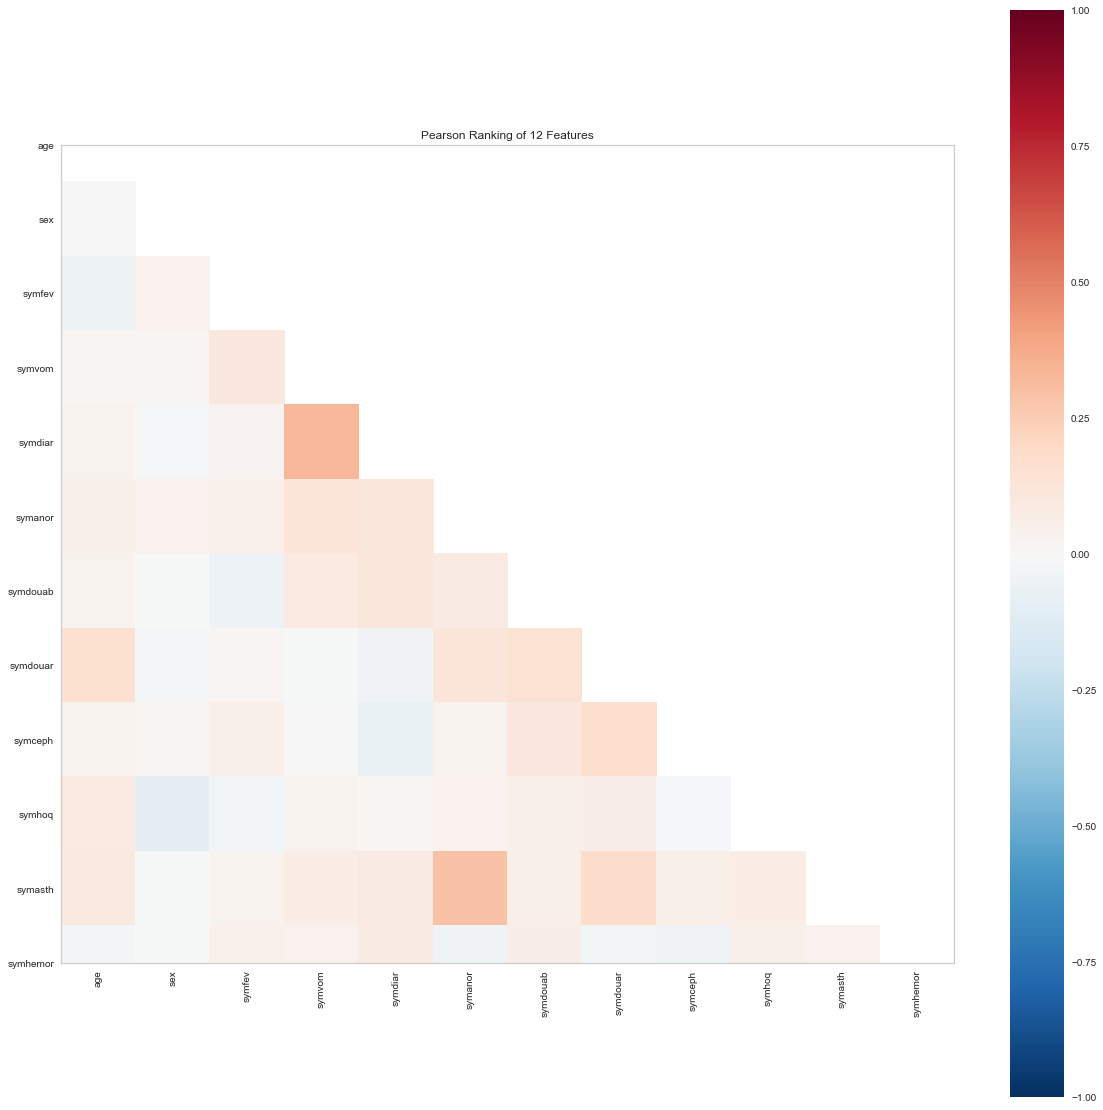

In [245]:
Corr_vision(X_ebo_simple)

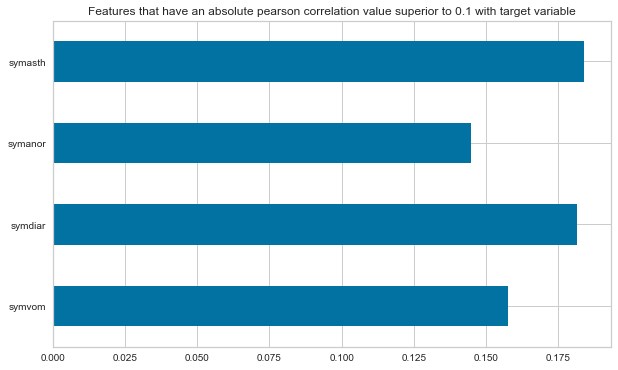

In [246]:
X_y = X_ebo_simple.join(y_ebo_simple)
corr_matrix = X_y.corr()

corr_y = corr_matrix['epistat']
threshold = 0.1  
fig, ax = plt.subplots(figsize=(10,6))
corr_y[corr_y.index[abs(corr_y) > threshold].tolist()].drop('epistat').plot(kind='barh')
plt.title('Features that have an absolute pearson correlation value superior to {} with target variable'.format(threshold))
plt.show()

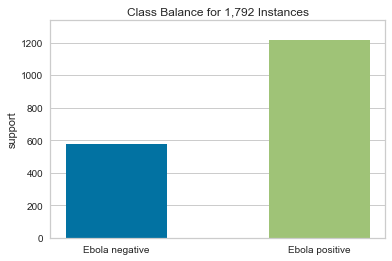

In [247]:
Imbalance(y_ebo_simple)

/Users/jeannafta/opt/anaconda3/lib/python3.7/site-packages/yellowbrick/features/radviz.py:199: RuntimeWarning: invalid value encountered in true_divide
  xy = (s * row_).sum(axis=0) / row.sum()


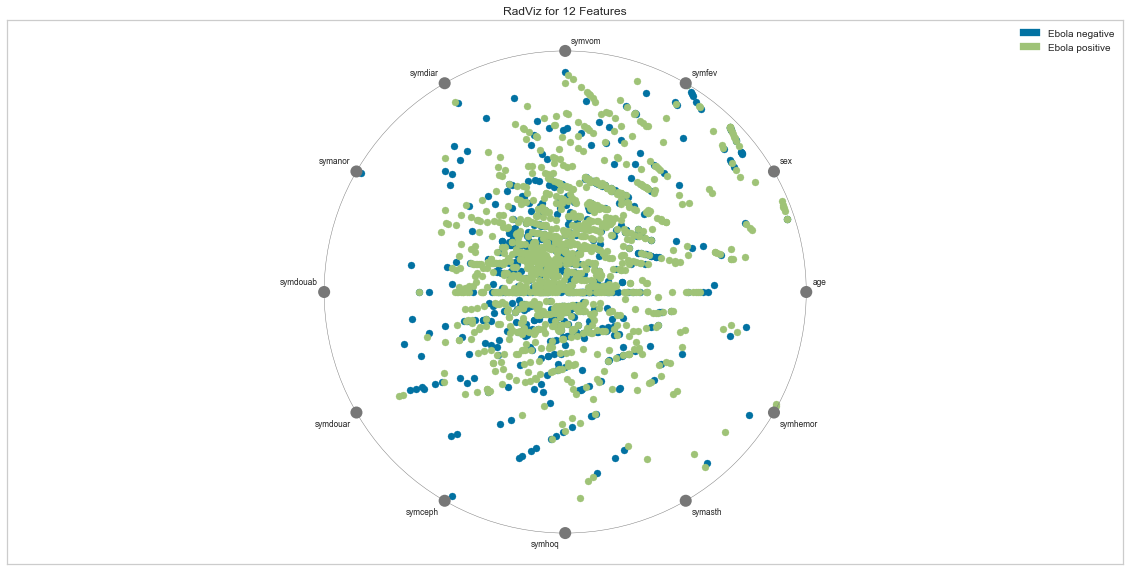

In [248]:
Rad_vision(X_ebo_simple, y_ebo_simple)

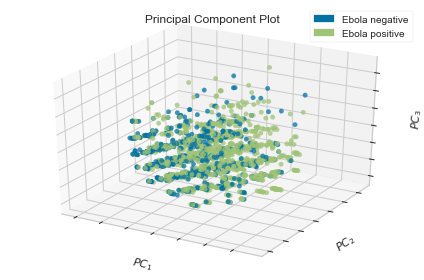

In [249]:
PCA_vision_3D(X_ebo_simple, y_ebo_simple.astype('int'))

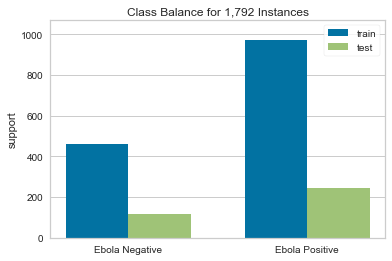

In [250]:

X_ebo_simple_train, X_ebo_simple_test, y_ebo_simple_train, y_ebo_simple_test = train_test_split(X_ebo_simple, y_ebo_simple, test_size=0.2, random_state=0, stratify=y_ebo_simple)


# Instantiate the visualizer
visualizer = ClassBalance(labels=['Ebola Negative', 'Ebola Positive'])

visualizer.fit(y_ebo_simple_train, y_ebo_simple_test)        # Fit the data to the visualizer
visualizer.show()                      # Finalize and render the figure
plt.show()

In [251]:
from sklearn.preprocessing import StandardScaler

# standardize age for df_ebo_simple

scaler1 = StandardScaler()
X_ebo_simple_train['age'] = scaler1.fit_transform(X_ebo_simple_train['age'].to_numpy().reshape(-1, 1))  
X_ebo_simple_test['age'] = scaler1.transform(X_ebo_simple_test['age'].to_numpy().reshape(-1, 1))

/Users/jeannafta/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/jeannafta/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


## ML models here

#### Decision tree

#### Random forest 

## Second proposition of data frame

In [252]:
df_ebo_extra = df_ebo
# delete all rows where y = -1 :
df_ebo_extra = df_ebo_extra[df_ebo_extra['epistat']!=-1]
df_ebo_extra = make_indicators(df_ebo_extra, df_ebo_extra.drop('epistat', axis=1).columns, [-1]*len(df_ebo_extra.drop('epistat', axis=1).columns), False)
df_ebo_extra                                                                                                    

,age,sex,symfev,symn,symv,symvom,symdiar,symfat,symanor,symdouab,...,hemtou_indicator,hemvag_indicator,hempet_indicator,hemuri_indicator,hemaut_indicator,contsusp_indicator,funvis_indicator,hospvis_indicator,anicon_indicator,anitiq_indicator
0,60.0,0.0,1.0,-1.0,-1.0,1.0,0.0,-1.0,-1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,35.0,0.0,1.0,-1.0,-1.0,1.0,1.0,-1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,40.0,1.0,1.0,-1.0,-1.0,0.0,0.0,-1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,40.0,1.0,1.0,-1.0,-1.0,0.0,1.0,-1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,8.0,0.0,1.0,-1.0,-1.0,0.0,1.0,-1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,-1.0,0.0,0.0,-1.0,-1.0,1.0,1.0,-1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2496,43.0,1.0,0.0,-1.0,-1.0,0.0,1.0,-1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2497,34.0,0.0,0.0,-1.0,-1.0,1.0,0.0,-1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2498,6.0,1.0,1.0,-1.0,-1.0,0.0,0.0,-1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [253]:
y_ebo_extra = df_ebo_extra['epistat'].astype(float)
X_ebo_extra = df_ebo_extra.drop(['epistat'], axis = 1).astype(float)

/Users/jeannafta/opt/anaconda3/lib/python3.7/site-packages/yellowbrick/features/rankd.py:216: YellowbrickWarning: RankD plots may be clipped when using matplotlib v3.1.1, upgrade to matplotlib v3.1.2 or later to fix the plots.
  warnings.warn(msg, YellowbrickWarning)


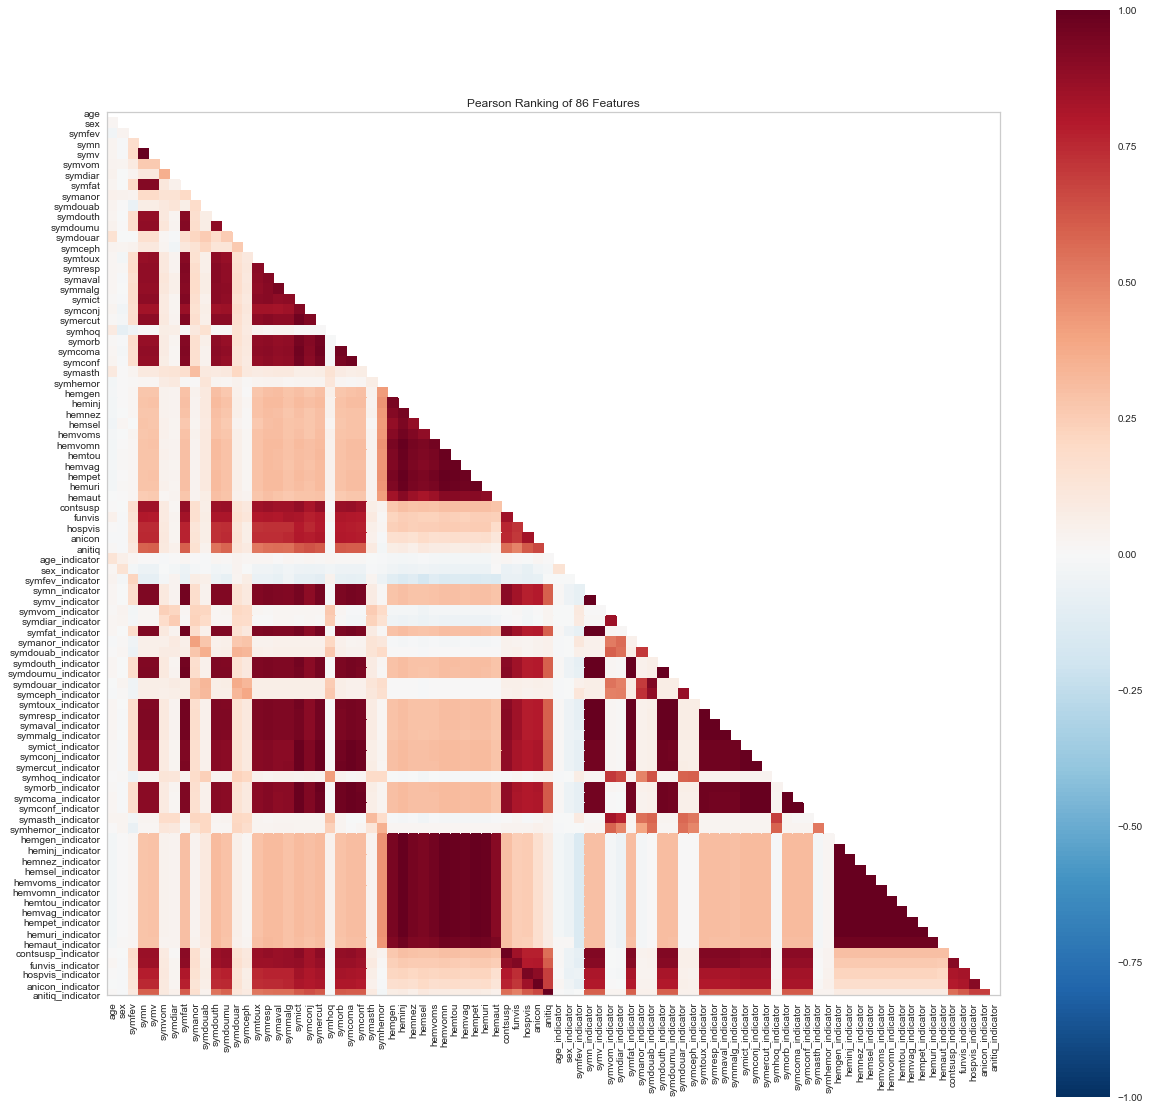

In [254]:
Corr_vision(X_ebo_extra)

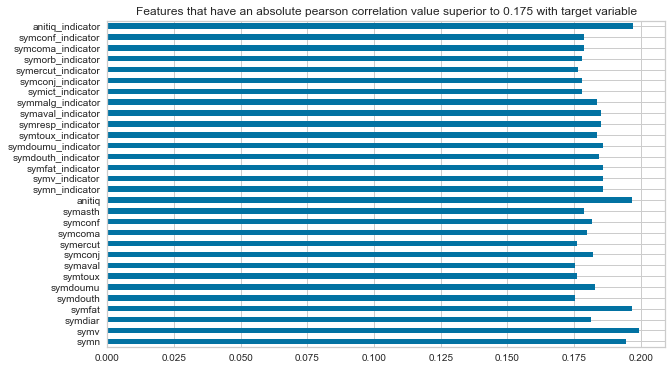

In [255]:
X_y = X_ebo_extra.join(y_ebo_extra)
corr_matrix = X_y.corr()

corr_y = corr_matrix['epistat']
threshold = 0.175
fig, ax = plt.subplots(figsize=(10,6))
corr_y[corr_y.index[abs(corr_y) > threshold].tolist()].drop('epistat').plot(kind='barh')
plt.title('Features that have an absolute pearson correlation value superior to {} with target variable'.format(threshold))
plt.show()

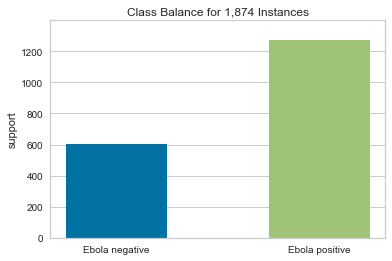

In [256]:
Imbalance(y_ebo_extra)

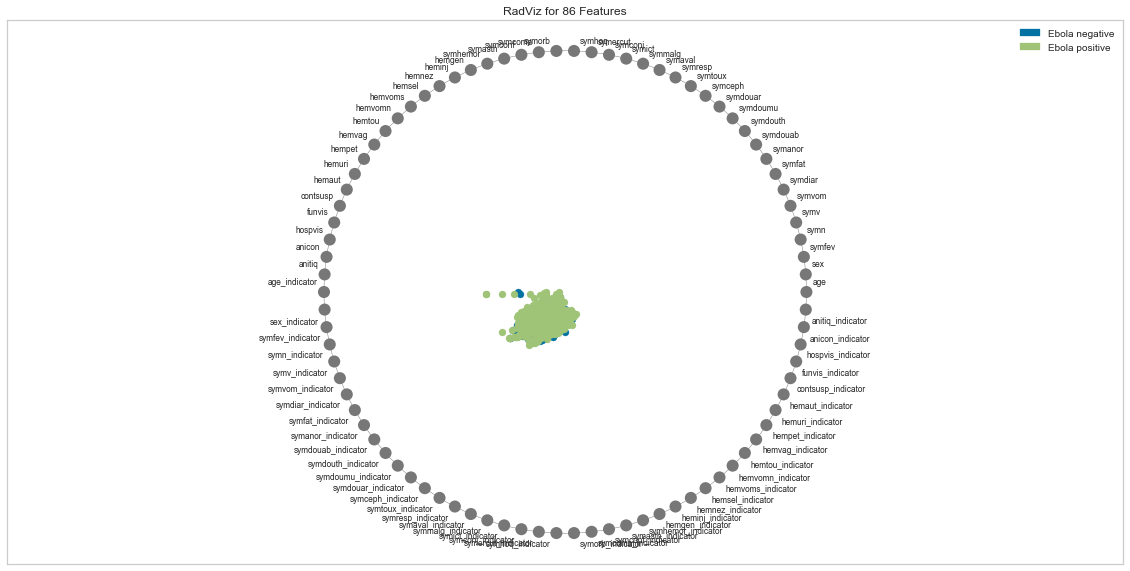

In [257]:
Rad_vision(X_ebo_extra, y_ebo_extra)

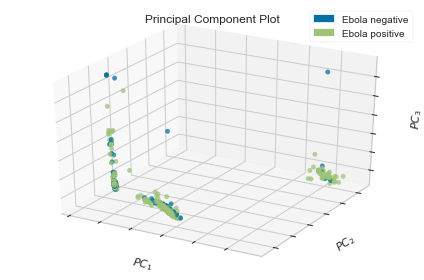

In [258]:
PCA_vision_3D(X_ebo_extra, y_ebo_extra.astype('int'))

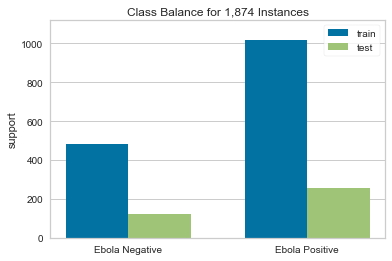

In [259]:
X_ebo_extra_train, X_ebo_extra_test, y_ebo_extra_train, y_ebo_extra_test = train_test_split(X_ebo_extra, y_ebo_extra, test_size=0.2, random_state=0, stratify=y_ebo_extra)

# Instantiate the visualizer
visualizer = ClassBalance(labels=['Ebola Negative', 'Ebola Positive'])

visualizer.fit(y_ebo_extra_train, y_ebo_extra_test)        # Fit the data to the visualizer
visualizer.show()                      # Finalize and render the figure
plt.show()

In [260]:
## standardize age

# change -1 to Nan so that it is not take into account when doing standardization 
X_ebo_extra_train['age'].replace(-1, np.nan, inplace=True)
X_ebo_extra_test['age'].replace(-1, np.nan, inplace=True)

# standardization
scaler2 = StandardScaler()
X_ebo_extra_train['age'] = scaler2.fit_transform(X_ebo_extra_train['age'].to_numpy().reshape(-1, 1))  
X_ebo_extra_test['age'] = scaler2.transform(X_ebo_extra_test['age'].to_numpy().reshape(-1, 1))

# we can rechange nans to -1 
X_ebo_extra_train['age'].replace(np.nan, -1, inplace=True)
X_ebo_extra_test['age'].replace(np.nan, -1, inplace=True)

/Users/jeannafta/opt/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:6786: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)
/Users/jeannafta/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/Users/jeannafta/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats

In [261]:
# sanity check 
print(sum(X_ebo_extra_train['age_indicator']==0))
print(sum(X_ebo_extra_train['age']==-1))

11
11


## ML models here

## Third proposition of data frame

In [264]:
df_rid = pd.read_csv("allFiles/Rid_frame.csv")

df_rid

,msfid,age,datmac_dayofyear,datgck_dayofyear,sex_F,sex_M,sex_U,symfev,symvom,symdiar,...,conttyp_Dead,conttyp_Unknown,funvis_No,funvis_Unknown,funvis_Yes,fundat_dayofyear,funcont_No,funcont_Unknown,funcont_Yes,epistat
0,G10,35.0,-1,-1,0,1,0,1,1,1,...,0,1,0,1,0,-1,0,1,0,1
1,G100,40.0,-1,101,1,0,0,1,0,0,...,0,1,0,1,0,-1,0,1,0,1
2,G1000,40.0,260,-1,1,0,0,1,0,1,...,0,1,0,1,0,-1,0,1,0,1
3,G1001,8.0,260,262,0,1,0,1,0,1,...,0,1,0,1,0,-1,0,1,0,1
4,G1002,12.0,258,262,0,1,0,1,1,1,...,1,0,1,0,0,-1,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1716,G995,30.0,-1,-1,0,1,0,0,1,1,...,0,1,0,1,0,-1,0,1,0,1
1717,G996,43.0,-1,261,1,0,0,0,0,1,...,0,1,0,1,0,-1,0,1,0,1
1718,G997,34.0,-1,262,0,1,0,0,1,0,...,0,1,0,1,0,-1,0,1,0,0
1719,G998,6.0,-1,260,1,0,0,1,0,0,...,0,1,0,1,0,-1,0,1,0,1


# REMEMBER TO USE VALIDATION CURVE TO GET AN IDEA ON THE HYPERPARAMETERS !
# REMEMBER TO DO CROSS VALIDATION FOR HYPERPARAMETERS; AND THEN UPDATING AND THEN CHECKING THE SCORES WITH FUNCTION IN HELPERS

In [265]:
# For ridha's dataframe for yeah 
X_ebo_ml = df_rid.drop(columns = ['msfid','epistat'])
y_ebo_ml = df_rid['epistat']

#### Correlation matrix 

/Users/jeannafta/opt/anaconda3/lib/python3.7/site-packages/yellowbrick/features/rankd.py:216: YellowbrickWarning: RankD plots may be clipped when using matplotlib v3.1.1, upgrade to matplotlib v3.1.2 or later to fix the plots.
  warnings.warn(msg, YellowbrickWarning)


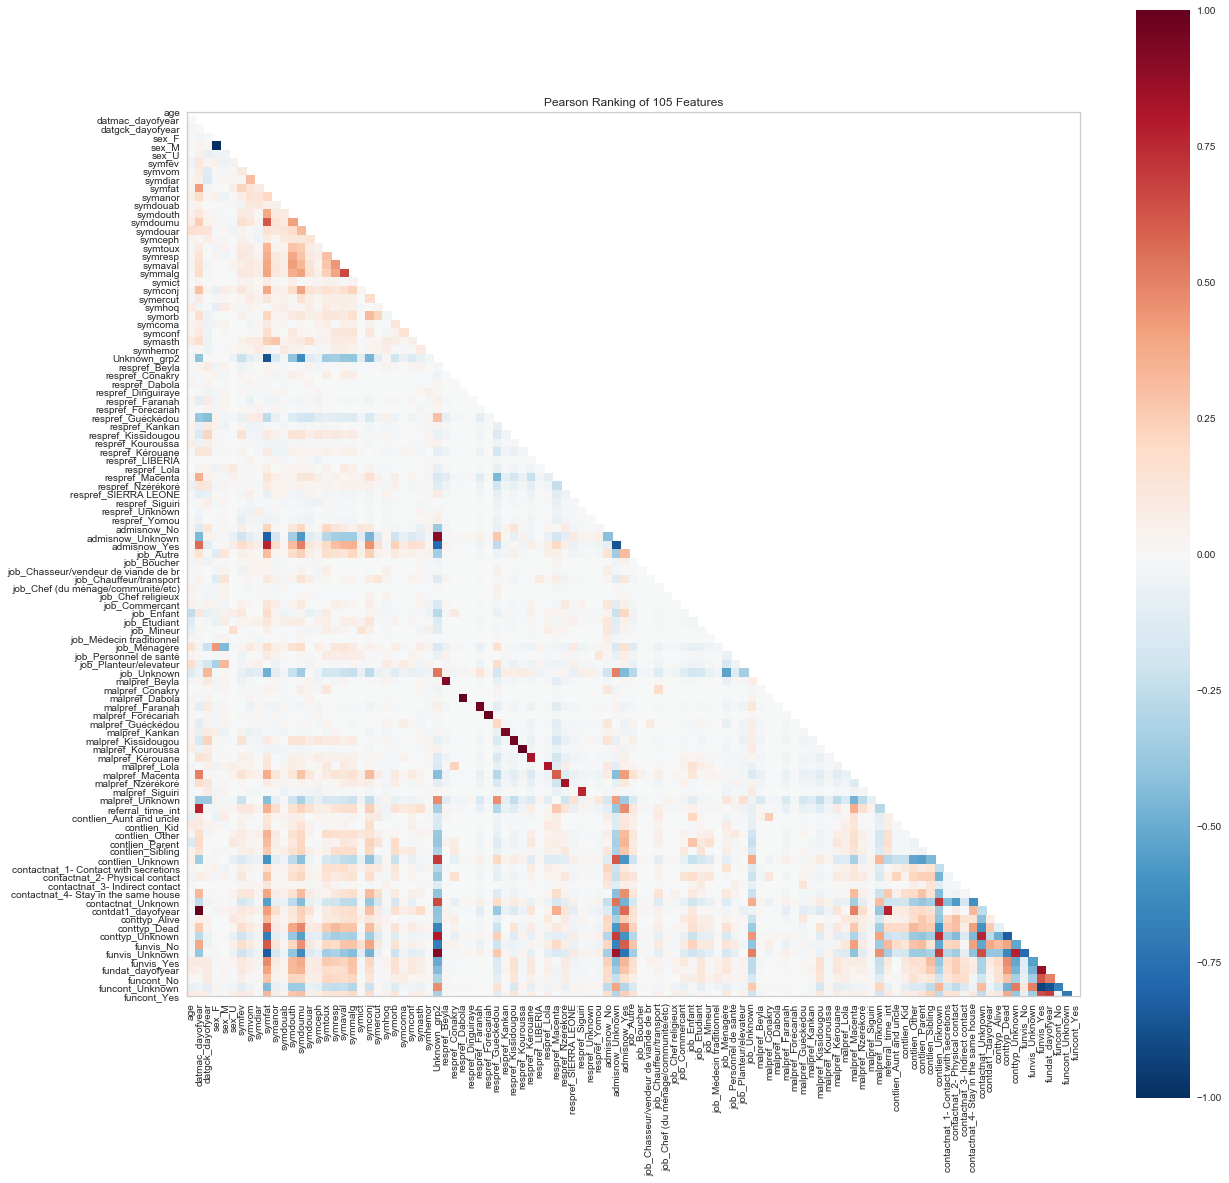

In [266]:
Corr_vision(X_ebo_ml)

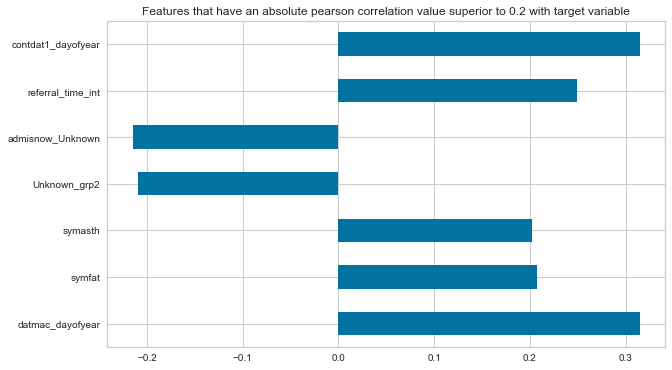

In [267]:
X_y = X_ebo_ml.join(y_ebo_ml)
corr_matrix = X_y.corr()

corr_y = corr_matrix['epistat']
threshold = 0.2
fig, ax = plt.subplots(figsize=(10,6))
corr_y[corr_y.index[abs(corr_y) > threshold].tolist()].drop('epistat').plot(kind='barh')
plt.title('Features that have an absolute pearson correlation value superior to {} with target variable'.format(threshold))
plt.show()

The values above are "correlated" with the output variable 'epistat' (ebola outcome), we expect them to be considered important during the model.

### Class imbalance

Balance is important in order to get a reliable accuracy for unseen datas, if imbalanced, steps need to be taken in order to take this into account. 
A good metric to look at is precision, recall and F1, this is discussed in the report. 

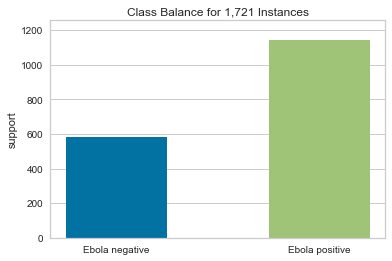

In [268]:
Imbalance(y_ebo_ml)

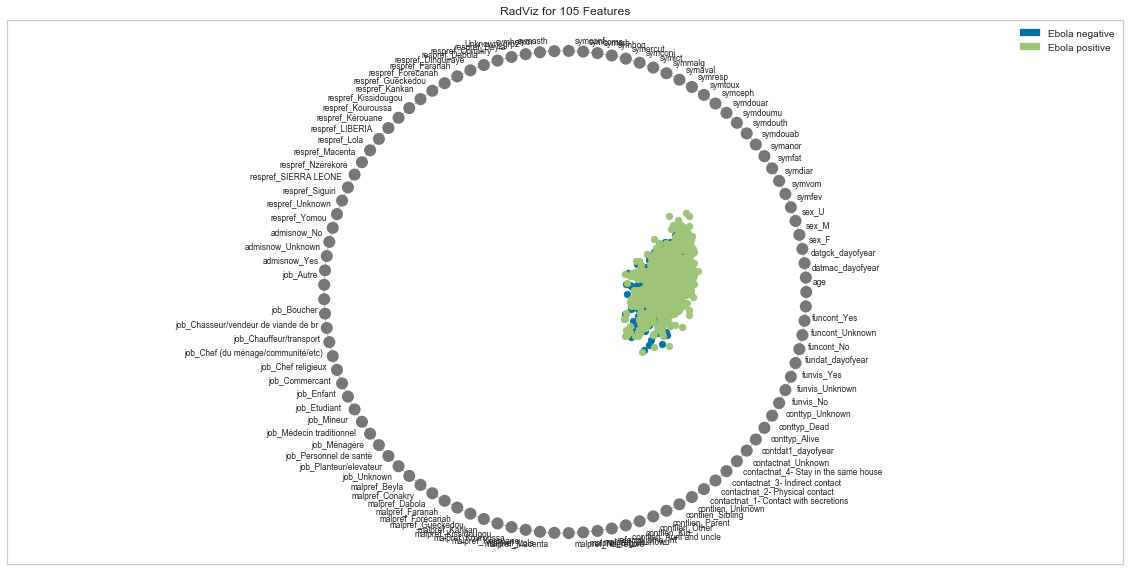

In [269]:
Rad_vision(X_ebo_ml, y_ebo_ml)

In [270]:
X_ebo_ml['respref_Dinguiraye'].value_counts()

0    1720
1       1
Name: respref_Dinguiraye, dtype: int64

The plot above does not tell us much, we would have wished for a distinction of colors between ebola positive and negative patients

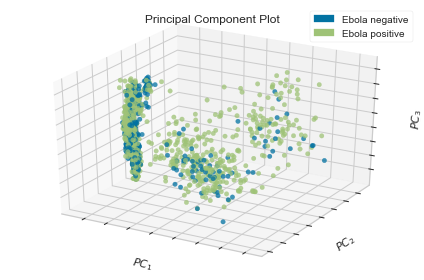

In [271]:
PCA_vision_3D(X_ebo_ml, y_ebo_ml)

#### How to interpret this 
Jean, Cdeic ? 

#### We are in a high dimension dataset, let's try Manifold

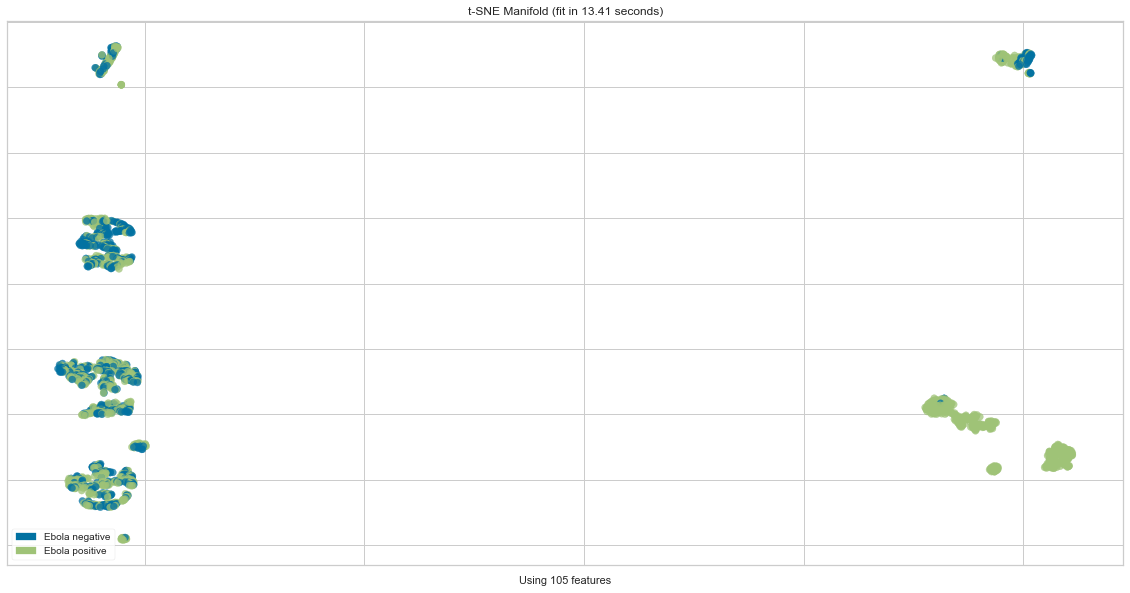

In [272]:
from yellowbrick.features import Manifold

fig, ax = plt.subplots(figsize=(20,10))
# Instantiate the visualizer
viz = Manifold(manifold="tsne",  classes=['Ebola negative', 'Ebola positive'])
viz.fit_transform(X_ebo_ml, y_ebo_ml)  # Fit the data to the visualizer
viz.show()               # Finalize and render the figure
plt.show()

##### Split train/test

Before standardizing, we need to make sure that the dataset is split between train and test !
This is to make sure that the "way" we standardize our train set is "the base" as to how we standardize our test set.

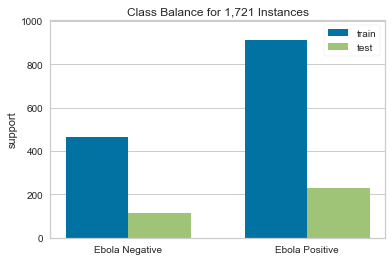

In [273]:

X_ebo_train, X_ebo_test, y_ebo_train, y_ebo_test = train_test_split(X_ebo_ml, y_ebo_ml, test_size=0.2, random_state=0, stratify=y_ebo_ml)


# Instantiate the visualizer
visualizer = ClassBalance(labels=['Ebola Negative', 'Ebola Positive'])

visualizer.fit(y_ebo_train, y_ebo_test)        # Fit the data to the visualizer
visualizer.show()                      # Finalize and render the figure
plt.show()

##### Normalizing the data


In [274]:
scaler3 = StandardScaler()
numerical_col = ['age','datmac_dayofyear', 'datgck_dayofyear', 'referral_time_int', 'contdat1_dayofyear','fundat_dayofyear']
X_ebo_train.loc[:,numerical_col] = scaler3.fit_transform(X_ebo_train[numerical_col])
X_ebo_test.loc[:,numerical_col] = scaler3.transform(X_ebo_test[numerical_col])

/Users/jeannafta/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/Users/jeannafta/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [566]:
########## The    data   is    now     normalized    ###################

## Jean and Ced, you can now use 

### SVM

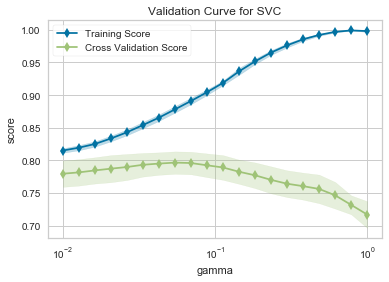

In [669]:
from sklearn.model_selection import StratifiedKFold 
from yellowbrick.model_selection import ValidationCurve
from sklearn.svm import SVC

# Validation curve for gamma parameter 
cv = StratifiedKFold(5)
param_range = np.logspace(-2, 0, 20)

viz = ValidationCurve(SVC(), param_name="gamma", param_range=param_range,logx=True, cv=cv, scoring="roc_auc", n_jobs=8)

viz.fit(X_ebo_train, y_ebo_train)
viz.show()
plt.show()

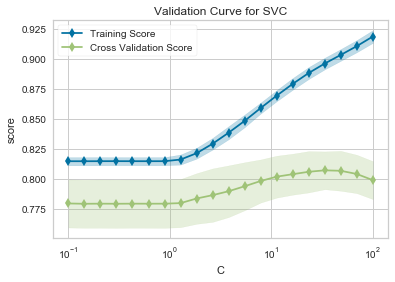

In [672]:
# Validation curve for C parameter 
cv = StratifiedKFold(5)
param_range = np.logspace(-1, 2, 20)

viz = ValidationCurve(SVC(), param_name="C", param_range=param_range,logx=True, cv=cv, scoring="roc_auc", n_jobs=8)

viz.fit(X_ebo_train, y_ebo_train)
viz.show()
plt.show()

In [673]:
from sklearn import svm

parameters = {'kernel':('linear', 'rbf', 'poly', 'sigmoid'), 'C': np.logspace(1, 2, 30), 'gamma' : np.logspace(-2, 0, 30)}
svc = svm.SVC()

clf = GridSearchCV(svc, parameters, scoring = 'roc_auc', n_jobs=-1)
clf.fit(X_ebo_train, y_ebo_train)

/Users/jeannafta/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': array([ 10.        ,  10.82636734,  11.72102...
       0.02212216, 0.02592944, 0.03039195, 0.03562248, 0.04175319,
       0.04893901, 0.05736153, 0.06723358, 0.07880463, 0.09236709,
       0.10826367, 0.1268961 , 0.14873521, 0.17433288, 0.20433597,
       0.23950266, 0.28072162, 0.32903446, 0.38566204, 0.45203537,
       0.52983169, 0.62101694, 0.72789538, 0.85316785, 1.        ]),
                         'kernel': ('linear', 'rbf', 'poly', 'sigmoid')},
             pre_dispatch='2*n_jobs', refit=True, return

In [674]:
clf.best_params_

{'C': 41.753189365604, 'gamma': 0.01, 'kernel': 'rbf'}

SVC:
On training we get an Accuracy 0.8190406976744186, an AUC 0.7941432244404113 and F1 score 0.864452912357104 
For test we get an Accuracy 0.7275362318840579, an AUC 0.6841590121969583 and F1 score 0.7991452991452992
Can plot ROC curve for this model
Don't have feature importance


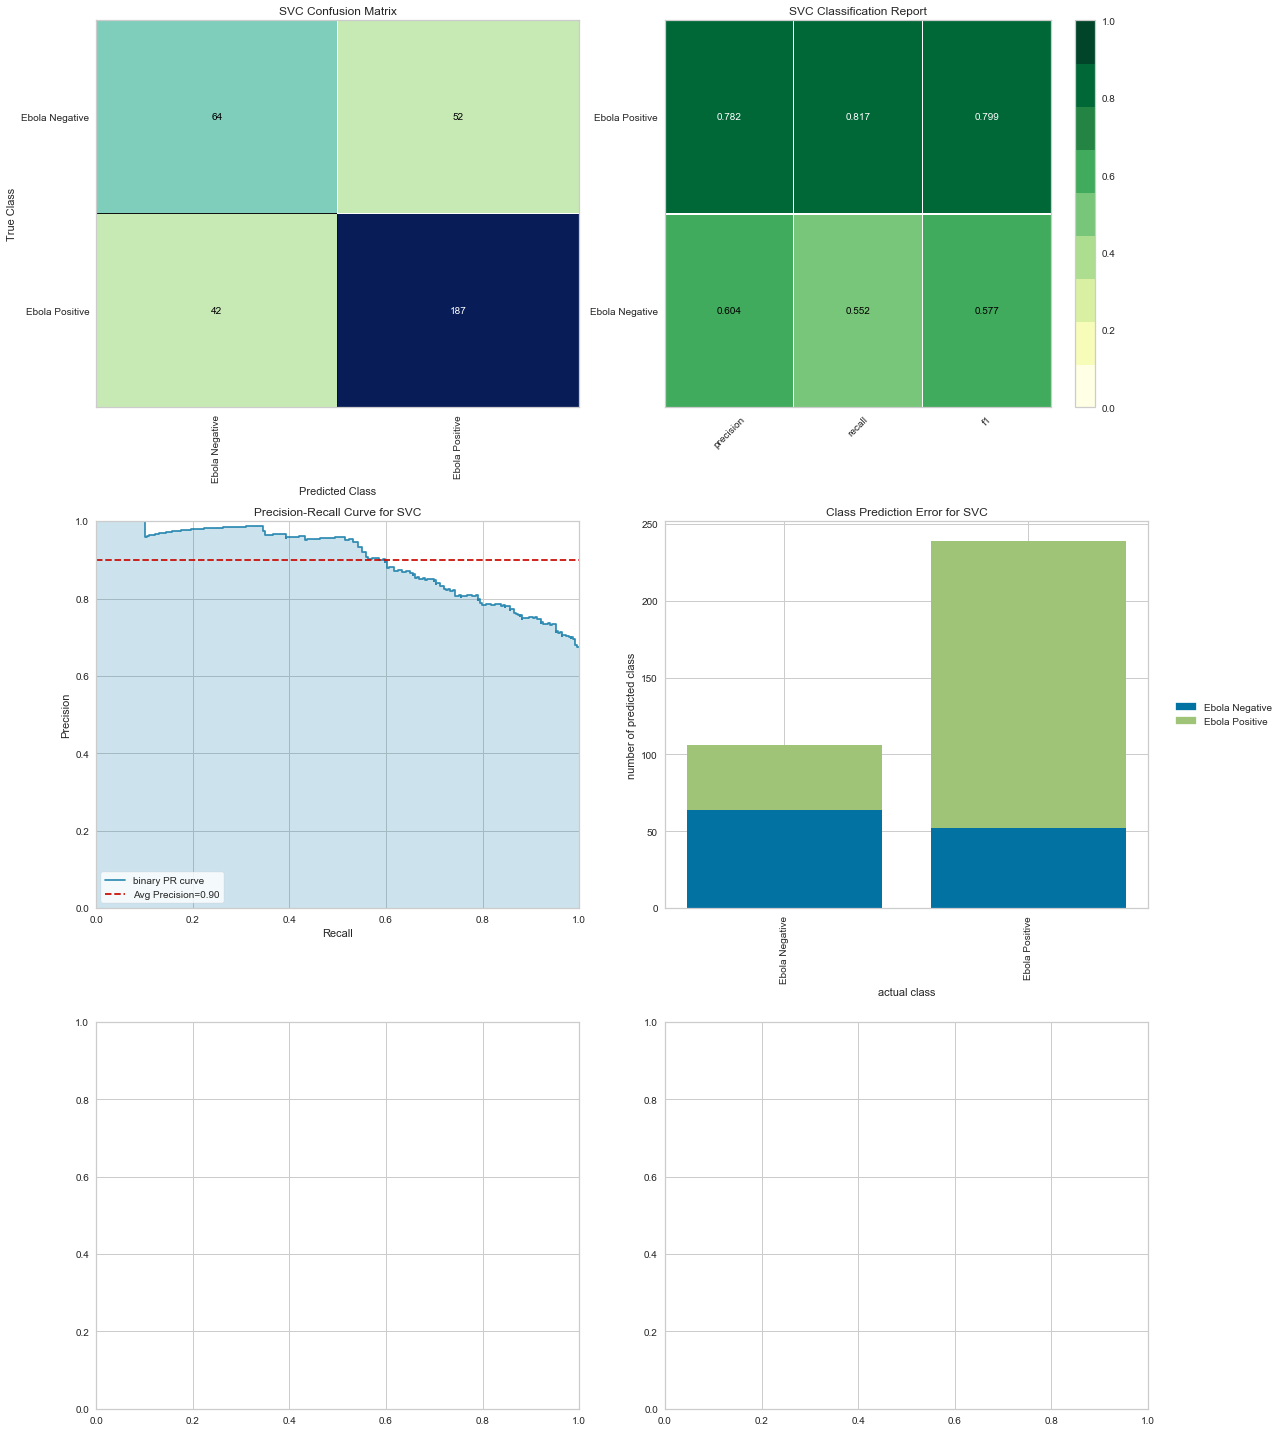

In [675]:
svc = svm.SVC(C= clf.best_params_['C'], gamma = clf.best_params_['gamma'], kernel = clf.best_params_['kernel'])
score_model(X_ebo_train, y_ebo_train, X_ebo_test, y_ebo_test, svc)

In [567]:
############################################################################################################################################

# Predictions outcome

### Outcome 

In [568]:
# apply dictionnary to get -1, 0, 1 for df_outcome  --> 0: recovery, 1: death, -1: unknown
df_outcome  = df_linelist['outcome']
dict_outcome_answer = {'1':'0', '2':'1', '3':'-1', '4':'-1', '9':'-1', '.':'-1'}
df_outcome = df_outcome.astype('str')
df_outcome = df_outcome.apply(lambda x : dict_outcome_answer[x])

### Assemble

In [569]:
# concatenate symptoms, age, sex and outcome (also add epistat so that we only keep ebola positive people)
df_out = pd.concat([df_age, df_sex, df_symp, df_outcome, df_ebola], axis = 1, join = 'outer').astype('int')
df_out = df_out[df_out['epistat']!=0]
df_out = df_out[df_out['epistat']!=-1]
print(df_out['epistat'].value_counts())
df_out.drop('epistat', axis=1, inplace = True)

# add constant column --> only for linear regression, SVM, etc
#df_out = sm.add_constant(df_out).astype('int')
df_out

1    1507
Name: epistat, dtype: int64


,age,sex,symfev,symn,symv,symvom,symdiar,symfat,symanor,symdouab,...,hemvag,hempet,hemuri,hemaut,contsusp,funvis,hospvis,anicon,anitiq,outcome
0,60,0,1,-1,-1,1,0,-1,-1,0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,1
1,35,0,1,-1,-1,1,1,-1,0,0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,1
2,40,1,1,-1,-1,0,0,-1,0,0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,0
3,40,1,1,-1,-1,0,1,-1,1,0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,1
4,8,0,1,-1,-1,0,1,-1,0,0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2494,26,1,1,-1,-1,1,1,-1,1,0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,1
2495,-1,0,0,-1,-1,1,1,-1,1,1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,1
2496,43,1,0,-1,-1,0,1,-1,0,1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,1
2498,6,1,1,-1,-1,0,0,-1,1,0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,1


### Feature processing

In [570]:
# first convert all -1 to NaN so that we can use the dropna() function
df_out.replace(-1, np.nan, inplace=True)
# then drop columns with only nans 
df_out.dropna(axis=0, how='all', subset=symptoms, inplace=True)
# convert all NaN to -1 
df_out.replace(np.nan, -1, inplace=True)
df_out   

,age,sex,symfev,symn,symv,symvom,symdiar,symfat,symanor,symdouab,...,hemvag,hempet,hemuri,hemaut,contsusp,funvis,hospvis,anicon,anitiq,outcome
0,60.0,0.0,1.0,-1.0,-1.0,1.0,0.0,-1.0,-1.0,0.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0
1,35.0,0.0,1.0,-1.0,-1.0,1.0,1.0,-1.0,0.0,0.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0
2,40.0,1.0,1.0,-1.0,-1.0,0.0,0.0,-1.0,0.0,0.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0
3,40.0,1.0,1.0,-1.0,-1.0,0.0,1.0,-1.0,1.0,0.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0
4,8.0,0.0,1.0,-1.0,-1.0,0.0,1.0,-1.0,0.0,0.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2494,26.0,1.0,1.0,-1.0,-1.0,1.0,1.0,-1.0,1.0,0.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0
2495,-1.0,0.0,0.0,-1.0,-1.0,1.0,1.0,-1.0,1.0,1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0
2496,43.0,1.0,0.0,-1.0,-1.0,0.0,1.0,-1.0,0.0,1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0
2498,6.0,1.0,1.0,-1.0,-1.0,0.0,0.0,-1.0,1.0,0.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0


## First proposition of data frame

In [571]:
df_out_simple = delete_minus1(df_out)
df_out_simple

,age,sex,symfev,symvom,symdiar,symanor,symdouab,symdouar,symceph,symhoq,symasth,symhemor,outcome
1,35.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
2,40.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
3,40.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,8.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
5,12.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2493,45.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
2494,26.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2496,43.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
2498,6.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0


In [572]:
from sklearn.preprocessing import StandardScaler
############## WRONG ! you need to standardize just like done on 3rd dataframe

## standardize age for df_out_simple

scaler1 = StandardScaler()
scaler1.fit(df_out_simple['age'].to_numpy().reshape(-1, 1))
df_out_simple['age'] = scaler1.transform(df_out_simple['age'].to_numpy().reshape(-1, 1))
df_out_simple

,age,sex,symfev,symvom,symdiar,symanor,symdouab,symdouar,symceph,symhoq,symasth,symhemor,outcome
1,0.139795,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
2,0.409060,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
3,0.409060,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,-1.314234,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
5,-1.098822,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2493,0.678324,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
2494,-0.344881,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2496,0.570619,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
2498,-1.421940,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0


In [573]:
y_out_simple = df_out_simple['outcome'].astype(float)
X_out_simple = df_out_simple.drop(['outcome'], axis = 1).astype(float)

/Users/jeannafta/opt/anaconda3/lib/python3.7/site-packages/yellowbrick/features/rankd.py:216: YellowbrickWarning: RankD plots may be clipped when using matplotlib v3.1.1, upgrade to matplotlib v3.1.2 or later to fix the plots.
  warnings.warn(msg, YellowbrickWarning)


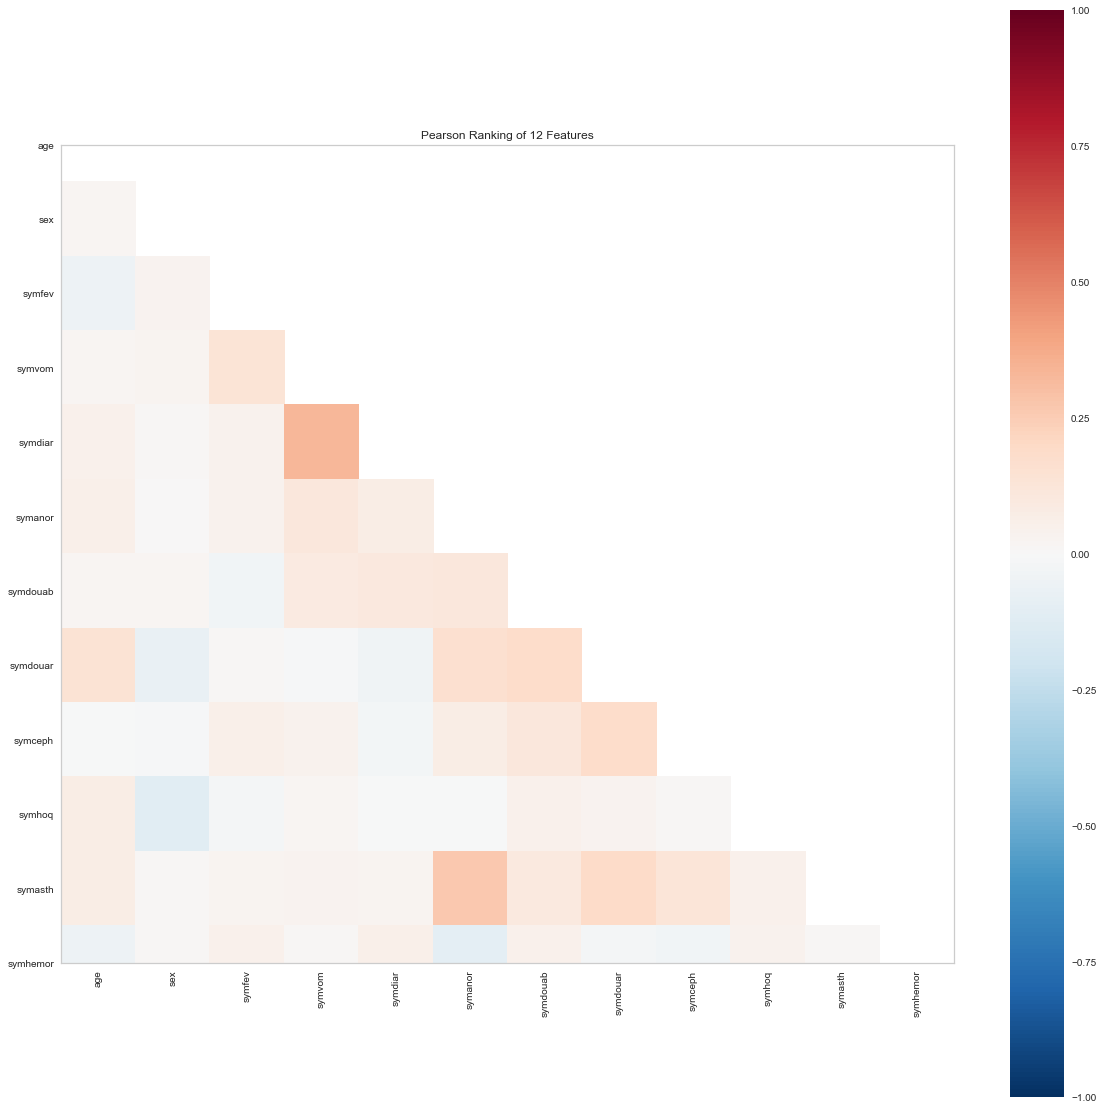

In [574]:
Corr_vision(X_out_simple)

## Second proposition of data frame

In [575]:
df_out_extra = df_out
df_out_extra = df_out_extra[df_out_extra['outcome']!=-1]     
# delete all rows where y = -1:
df_out_extra = make_indicators(df_out_extra, df_out_extra.drop('outcome', axis=1).columns, [-1]*len(df_out_extra.drop('outcome', axis=1).columns), False)   # apply Cédric's function
df_out_extra

,age,sex,symfev,symn,symv,symvom,symdiar,symfat,symanor,symdouab,...,hemtou_indicator,hemvag_indicator,hempet_indicator,hemuri_indicator,hemaut_indicator,contsusp_indicator,funvis_indicator,hospvis_indicator,anicon_indicator,anitiq_indicator
0,60.0,0.0,1.0,-1.0,-1.0,1.0,0.0,-1.0,-1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,35.0,0.0,1.0,-1.0,-1.0,1.0,1.0,-1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,40.0,1.0,1.0,-1.0,-1.0,0.0,0.0,-1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,40.0,1.0,1.0,-1.0,-1.0,0.0,1.0,-1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,8.0,0.0,1.0,-1.0,-1.0,0.0,1.0,-1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2494,26.0,1.0,1.0,-1.0,-1.0,1.0,1.0,-1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2495,-1.0,0.0,0.0,-1.0,-1.0,1.0,1.0,-1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2496,43.0,1.0,0.0,-1.0,-1.0,0.0,1.0,-1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2498,6.0,1.0,1.0,-1.0,-1.0,0.0,0.0,-1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [576]:
## standardize age for df_out_extra

# change -1 to Nan so that it is not take into account when doing standardization 
df_out_extra['age'].replace(-1, np.nan, inplace=True)
df_out_extra

# standardization
scaler2 = StandardScaler()
scaler2.fit(df_out_extra['age'].to_numpy().reshape(-1, 1))
df_out_extra['age'] = scaler2.transform(df_out_extra['age'].to_numpy().reshape(-1, 1))

# we can rechange nans to -1 
df_out_extra['age'].replace(np.nan, -1, inplace=True)
df_out_extra

,age,sex,symfev,symn,symv,symvom,symdiar,symfat,symanor,symdouab,...,hemtou_indicator,hemvag_indicator,hempet_indicator,hemuri_indicator,hemaut_indicator,contsusp_indicator,funvis_indicator,hospvis_indicator,anicon_indicator,anitiq_indicator
0,1.478582,0.0,1.0,-1.0,-1.0,1.0,0.0,-1.0,-1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.133407,0.0,1.0,-1.0,-1.0,1.0,1.0,-1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.402442,1.0,1.0,-1.0,-1.0,0.0,0.0,-1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.402442,1.0,1.0,-1.0,-1.0,0.0,1.0,-1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-1.319381,0.0,1.0,-1.0,-1.0,0.0,1.0,-1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2494,-0.350856,1.0,1.0,-1.0,-1.0,1.0,1.0,-1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2495,-1.000000,0.0,0.0,-1.0,-1.0,1.0,1.0,-1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2496,0.563863,1.0,0.0,-1.0,-1.0,0.0,1.0,-1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2498,-1.426995,1.0,1.0,-1.0,-1.0,0.0,0.0,-1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [577]:
# sanity check 
print(sum(df_out_extra['age_indicator']==0))
print(sum(df_out_extra['age']==-1))

print(sum(df_out_extra['outcome']==0))
print(sum(df_out_extra['outcome']==1))

7
7
446
821


In [578]:
y_out_extra = df_out_extra['outcome'].astype(float)
X_out_extra = df_out_extra.drop(['outcome'], axis = 1).astype(float)

/Users/jeannafta/opt/anaconda3/lib/python3.7/site-packages/yellowbrick/features/rankd.py:216: YellowbrickWarning: RankD plots may be clipped when using matplotlib v3.1.1, upgrade to matplotlib v3.1.2 or later to fix the plots.
  warnings.warn(msg, YellowbrickWarning)


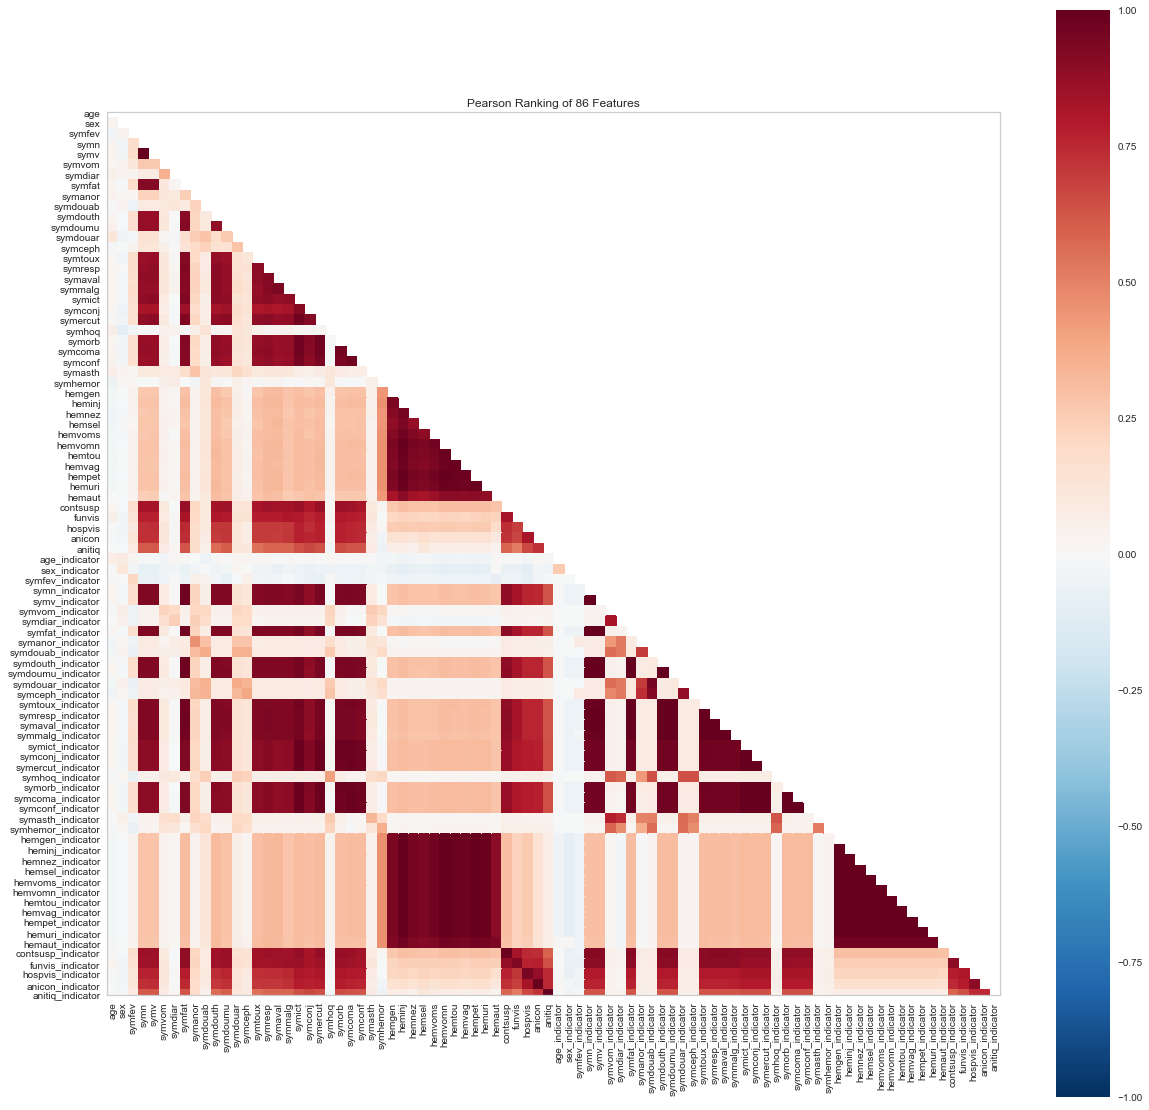

In [579]:
Corr_vision(X_out_extra)  # very high correlation between some features so 

## Third proposition of data frame for outcome 

In [580]:
df_rid

,msfid,age,datmac_dayofyear,datgck_dayofyear,sex_F,sex_M,sex_U,symfev,symvom,symdiar,...,conttyp_Dead,conttyp_Unknown,funvis_No,funvis_Unknown,funvis_Yes,fundat_dayofyear,funcont_No,funcont_Unknown,funcont_Yes,epistat
0,G10,35.0,-1,-1,0,1,0,1,1,1,...,0,1,0,1,0,-1,0,1,0,1
1,G100,40.0,-1,101,1,0,0,1,0,0,...,0,1,0,1,0,-1,0,1,0,1
2,G1000,40.0,260,-1,1,0,0,1,0,1,...,0,1,0,1,0,-1,0,1,0,1
3,G1001,8.0,260,262,0,1,0,1,0,1,...,0,1,0,1,0,-1,0,1,0,1
4,G1002,12.0,258,262,0,1,0,1,1,1,...,1,0,1,0,0,-1,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1716,G995,30.0,-1,-1,0,1,0,0,1,1,...,0,1,0,1,0,-1,0,1,0,1
1717,G996,43.0,-1,261,1,0,0,0,0,1,...,0,1,0,1,0,-1,0,1,0,1
1718,G997,34.0,-1,262,0,1,0,0,1,0,...,0,1,0,1,0,-1,0,1,0,0
1719,G998,6.0,-1,260,1,0,0,1,0,0,...,0,1,0,1,0,-1,0,1,0,1


First concatenate df_outcome (cleaned, but we need to still remove -1 "the unknwons") with msfid, in order to merge with df_rid 



In [581]:
df_outcome = df_outcome.astype('int')
df_temp = pd.concat([df_outcome, df_linelist['msfid']], axis = 1, join = 'outer')
df_temp

,outcome,msfid
0,1,G1
1,1,G10
2,0,G100
3,1,G1000
4,1,G1001
...,...,...
2495,1,G995
2496,1,G996
2497,-1,G997
2498,1,G998


In [582]:
df_out_rid = df_temp[df_temp['outcome'] != -1]
df_out_rid = df_out_rid.merge(df_rid,on = 'msfid')
# We predict the outcome only on ebola postive people, by outcome we mean (dead, not dead)
df_out_rid['epistat'] =df_out_rid['epistat'].replace(0, np.nan)
df_out_rid.dropna(axis = 0, inplace = True)
df_out_rid

,outcome,msfid,age,datmac_dayofyear,datgck_dayofyear,sex_F,sex_M,sex_U,symfev,symvom,...,conttyp_Dead,conttyp_Unknown,funvis_No,funvis_Unknown,funvis_Yes,fundat_dayofyear,funcont_No,funcont_Unknown,funcont_Yes,epistat
0,1,G10,35.0,-1,-1,0,1,0,1,1,...,0,1,0,1,0,-1,0,1,0,1.0
1,0,G100,40.0,-1,101,1,0,0,1,0,...,0,1,0,1,0,-1,0,1,0,1.0
2,1,G1000,40.0,260,-1,1,0,0,1,0,...,0,1,0,1,0,-1,0,1,0,1.0
3,1,G1001,8.0,260,262,0,1,0,1,0,...,0,1,0,1,0,-1,0,1,0,1.0
4,0,G1002,12.0,258,262,0,1,0,1,1,...,1,0,1,0,0,-1,0,1,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1165,1,G994,26.0,-1,261,1,0,0,1,1,...,0,1,0,1,0,-1,0,1,0,1.0
1166,1,G995,30.0,-1,-1,0,1,0,0,1,...,0,1,0,1,0,-1,0,1,0,1.0
1167,1,G996,43.0,-1,261,1,0,0,0,0,...,0,1,0,1,0,-1,0,1,0,1.0
1168,1,G998,6.0,-1,260,1,0,0,1,0,...,0,1,0,1,0,-1,0,1,0,1.0


In [583]:
# Let's drop msfid and epistat

df_out_rid.drop(['msfid','epistat'], inplace= True, axis = 1)


In [584]:
# This is now the third dataframe to predict the outcome knowing your patient is positive 
df_out_rid

,outcome,age,datmac_dayofyear,datgck_dayofyear,sex_F,sex_M,sex_U,symfev,symvom,symdiar,...,conttyp_Alive,conttyp_Dead,conttyp_Unknown,funvis_No,funvis_Unknown,funvis_Yes,fundat_dayofyear,funcont_No,funcont_Unknown,funcont_Yes
0,1,35.0,-1,-1,0,1,0,1,1,1,...,0,0,1,0,1,0,-1,0,1,0
1,0,40.0,-1,101,1,0,0,1,0,0,...,0,0,1,0,1,0,-1,0,1,0
2,1,40.0,260,-1,1,0,0,1,0,1,...,0,0,1,0,1,0,-1,0,1,0
3,1,8.0,260,262,0,1,0,1,0,1,...,0,0,1,0,1,0,-1,0,1,0
4,0,12.0,258,262,0,1,0,1,1,1,...,0,1,0,1,0,0,-1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1165,1,26.0,-1,261,1,0,0,1,1,1,...,0,0,1,0,1,0,-1,0,1,0
1166,1,30.0,-1,-1,0,1,0,0,1,1,...,0,0,1,0,1,0,-1,0,1,0
1167,1,43.0,-1,261,1,0,0,0,0,1,...,0,0,1,0,1,0,-1,0,1,0
1168,1,6.0,-1,260,1,0,0,1,0,0,...,0,0,1,0,1,0,-1,0,1,0


In [585]:
# For ridha's dataframe for yeah 
X_out_ml = df_out_rid.drop(columns = ['outcome'])
y_out_ml = df_out_rid['outcome']

#### We note that this column has only zero and we'll drop it

In [586]:
X_out_ml['respref_Dinguiraye'].value_counts()

0    1137
Name: respref_Dinguiraye, dtype: int64

In [587]:
X_out_ml.drop(columns=['respref_Dinguiraye'], inplace = True)

#### Correlation matrix 

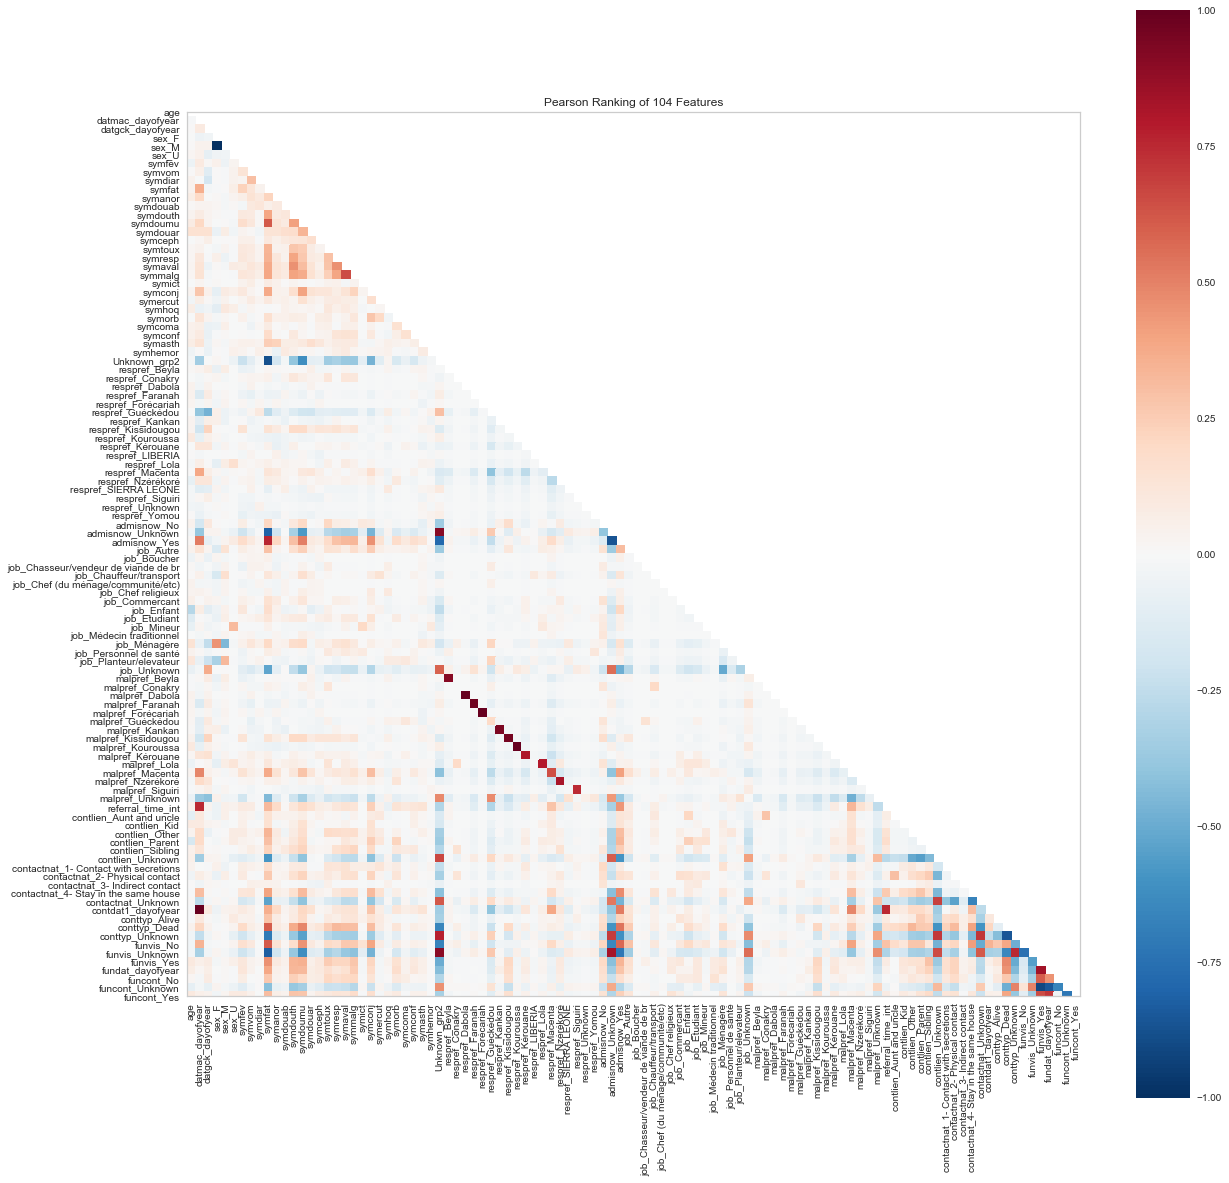

In [588]:
Corr_vision(X_out_ml)

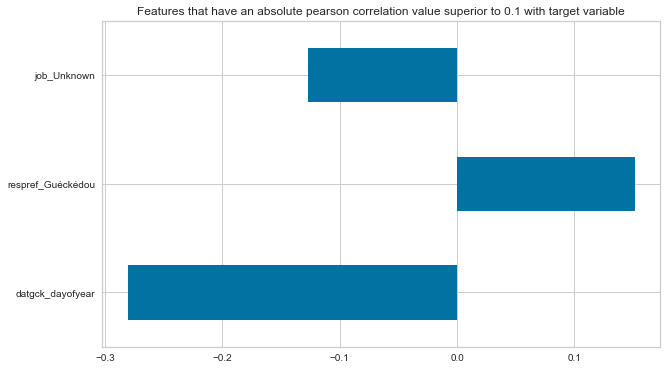

In [589]:
X_y_out = X_out_ml.join(y_out_ml, how = 'outer')
corr_matrix = X_y_out.corr()

corr_y = corr_matrix['outcome']
threshold = 0.1
fig, ax = plt.subplots(figsize=(10,6))
corr_y[corr_y.index[abs(corr_y) > threshold].tolist()].drop('outcome').plot(kind='barh')
plt.title('Features that have an absolute pearson correlation value superior to {} with target variable'.format(threshold))
plt.show()



### Class imbalance

Balance is important in order to get a reliable accuracy for unseen datas, if imbalanced, steps need to be taken in order to take this into account. 
A good metric to look at is precision, recall and F1, this is discussed in the report. 

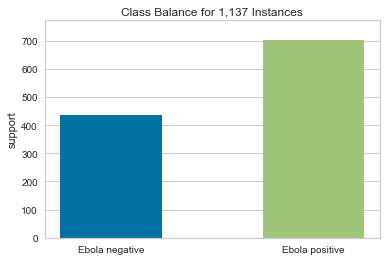

In [590]:
Imbalance(y_out_ml)

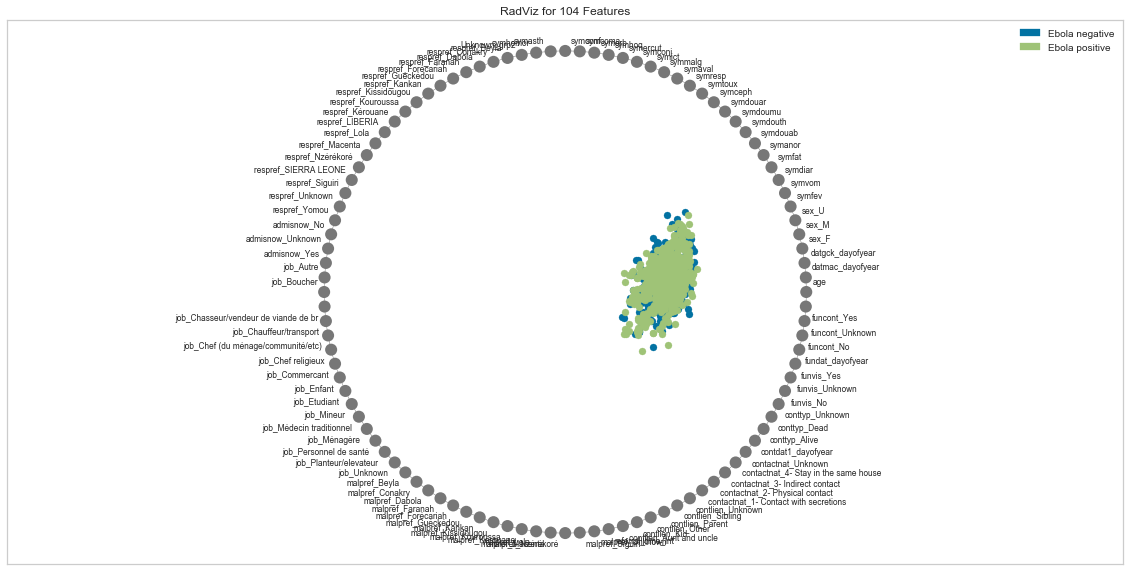

In [591]:
Rad_vision(X_out_ml, y_out_ml)

The plot above does not tell us much, we would have wished for a distinction of colors between ebola positive and negative patients

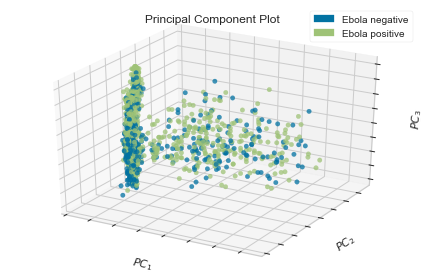

In [592]:
PCA_vision_3D(X_out_ml, y_out_ml)

#### How to interpret this 
Jean, Cdeic ? 

#### We are in a high dimension dataset, let's try Manifold

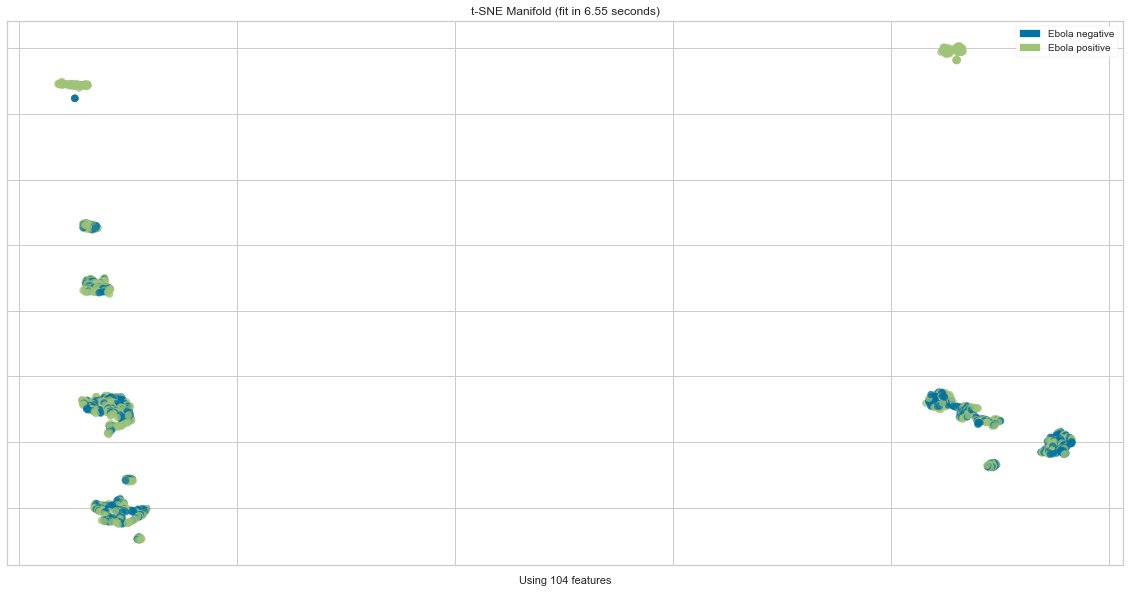

In [593]:
from yellowbrick.features import Manifold

fig, ax = plt.subplots(figsize=(20,10))
# Instantiate the visualizer
viz = Manifold(manifold="tsne",  classes=['Ebola negative', 'Ebola positive'])
viz.fit_transform(X_out_ml, y_out_ml)  # Fit the data to the visualizer
viz.show()               # Finalize and render the figure
plt.show()

##### Split train/test

Before standardizing, we need to make sure that the dataset is split between train and test !
This is to make sure that the "way" we standardize our train set is "the base" as to how we standardize our test set.

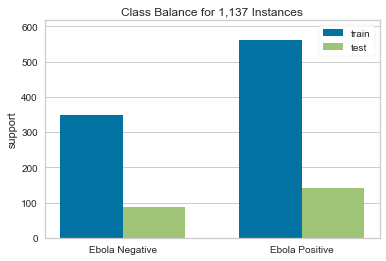

In [594]:

X_out_train, X_out_test, y_out_train, y_out_test = train_test_split(X_out_ml, y_out_ml, test_size=0.2, random_state=0, stratify=y_out_ml)


# Instantiate the visualizer
visualizer = ClassBalance(labels=['Ebola Negative', 'Ebola Positive'])

visualizer.fit(y_out_train, y_out_test)        # Fit the data to the visualizer
visualizer.show()                      # Finalize and render the figure
plt.show()

##### Normalizing the data


In [595]:
scaler3 = StandardScaler()
numerical_col = ['age','datmac_dayofyear', 'datgck_dayofyear', 'referral_time_int', 'contdat1_dayofyear','fundat_dayofyear']
X_out_train.loc[:,numerical_col] = scaler3.fit_transform(X_out_train[numerical_col])
X_out_test.loc[:,numerical_col] = scaler3.transform(X_out_test[numerical_col])

/Users/jeannafta/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/Users/jeannafta/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [596]:
########## The    data   is    now     normalized    ###################

## Jean and Ced, you can now use 

### SVM

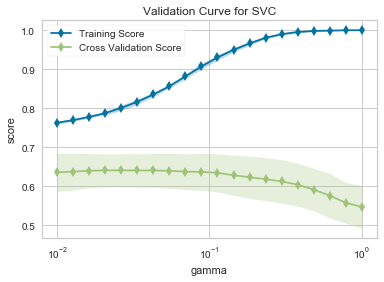

In [647]:
from sklearn.model_selection import StratifiedKFold 
from yellowbrick.model_selection import ValidationCurve
from sklearn.svm import SVC

# Validation curve for gamma parameter 
cv = StratifiedKFold(5)
param_range = np.logspace(-2, 0, 20)

viz = ValidationCurve(SVC(), param_name="gamma", param_range=param_range,logx=True, cv=cv, scoring="roc_auc", n_jobs=8)

viz.fit(X_out_train, y_out_train)
viz.show()
plt.show()

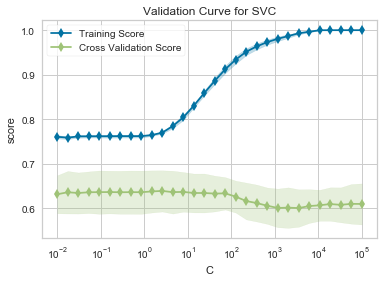

In [652]:
# Validation curve for C parameter 
cv = StratifiedKFold(5)
param_range = np.logspace(-2, 5, 30)

viz = ValidationCurve(SVC(), param_name="C", param_range=param_range,logx=True, cv=cv, scoring="roc_auc", n_jobs=8)

viz.fit(X_out_train, y_out_train)
viz.show()
plt.show()

In [657]:
from sklearn import svm

parameters = {'kernel':('linear', 'rbf', 'poly', 'sigmoid'), 'C': np.logspace(0, 2, 30), 'gamma' : np.logspace(-2, 0, 30)}
svc = svm.SVC()

clf = GridSearchCV(svc, parameters, scoring = 'roc_auc', n_jobs=-1)
clf.fit(X_out_train, y_out_train)

/Users/jeannafta/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': array([  1.        ,   1.1721023 ,   1.3738238 ,   1...
       0.02212216, 0.02592944, 0.03039195, 0.03562248, 0.04175319,
       0.04893901, 0.05736153, 0.06723358, 0.07880463, 0.09236709,
       0.10826367, 0.1268961 , 0.14873521, 0.17433288, 0.20433597,
       0.23950266, 0.28072162, 0.32903446, 0.38566204, 0.45203537,
       0.52983169, 0.62101694, 0.72789538, 0.85316785, 1.        ]),
                         'kernel': ('linear', 'rbf', 'poly', 'sigmoid')},
             pre_dispatch='2*n_jobs', refit=True

In [658]:
clf.best_params_

{'C': 9.23670857187386, 'gamma': 0.0117210229753348, 'kernel': 'rbf'}

SVC:
On training we get an Accuracy 0.7370737073707371, an AUC 0.6877036080890037 and F1 score 0.8083400160384925 
For test we get an Accuracy 0.6008771929824561, an AUC 0.549645390070922 and F1 score 0.7035830618892509
Can plot ROC curve for this model
Don't have feature importance


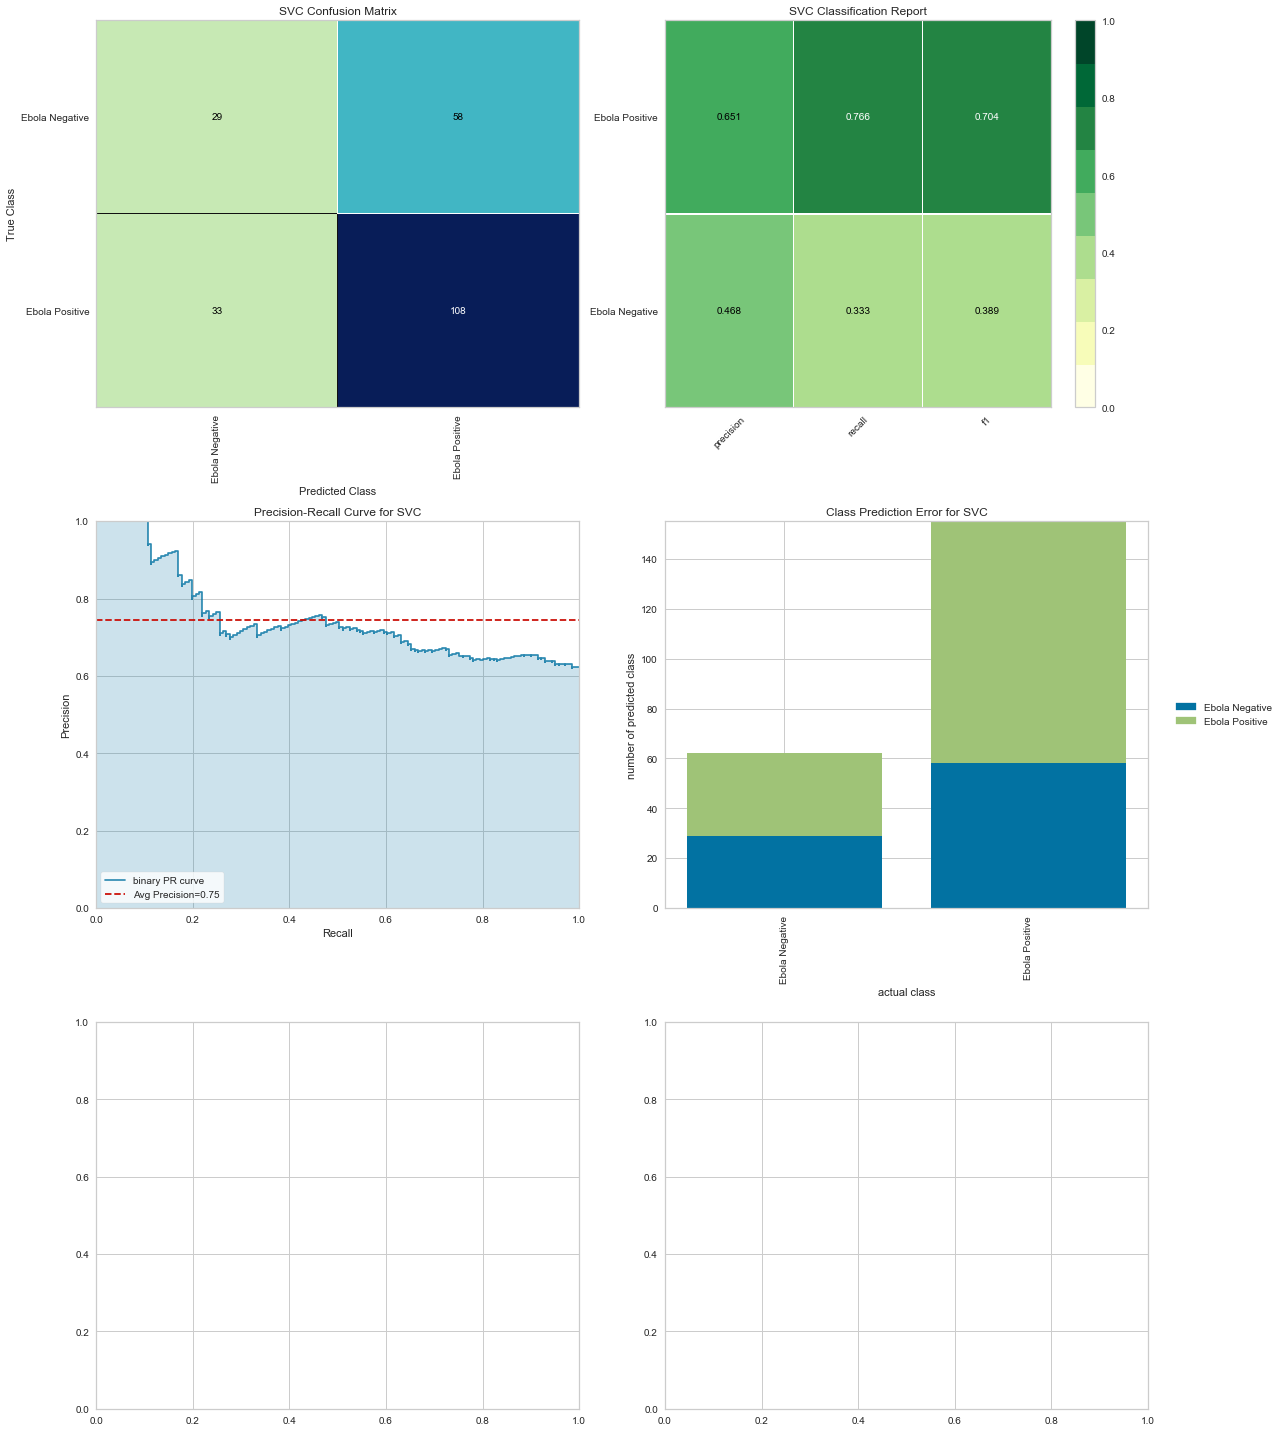

In [659]:
svc = svm.SVC(C= clf.best_params_['C'], gamma = clf.best_params_['gamma'], kernel = clf.best_params_['kernel'])
score_model(X_out_train, y_out_train, X_out_test, y_out_test, svc)

### Logistic regression

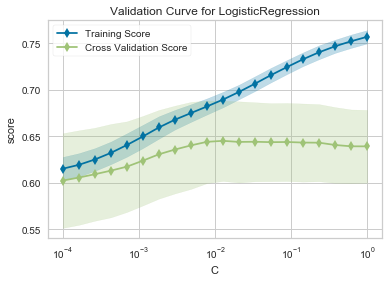

In [661]:
# Validation curve for C parameter 
cv = StratifiedKFold(5)
param_range = np.logspace(-4, 0, 20)

viz = ValidationCurve(LogisticRegression(), param_name="C", param_range=param_range,logx=True, cv=cv, scoring="roc_auc", n_jobs=-1)

viz.fit(X_out_train, y_out_train)
viz.show()
plt.show()

In [665]:
parameters = {'penalty': ['l1', 'l2'], 'C' : np.logspace(-3, -1, 30)}
logit = LogisticRegression()

clf = GridSearchCV(logit, parameters, scoring = 'roc_auc', n_jobs=-1)
clf.fit(X_out_train, y_out_train)

/Users/jeannafta/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/jeannafta/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': array([0.001     ,...
       0.00221222, 0.00259294, 0.0030392 , 0.00356225, 0.00417532,
       0.0048939 , 0.00573615, 0.00672336, 0.00788046, 0.00923671,
       0.01082637, 0.01268961, 0.01487352, 0.01743329, 0.0204336 ,
       0.02395027, 0.02807216, 0.03290345, 0.0385662 , 0.04520354,
       0.05298317, 0

In [666]:
clf.best_params_

{'C': 0.0727895384398315, 'penalty': 'l2'}

/Users/jeannafta/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression:
On training we get an Accuracy 0.6600660066006601, an AUC 0.6040398918187966 and F1 score 0.7537848605577689 
For test we get an Accuracy 0.6447368421052632, an AUC 0.5807043286867204 and F1 score 0.7476635514018691
Can plot ROC curve for this model
Don't have feature importance


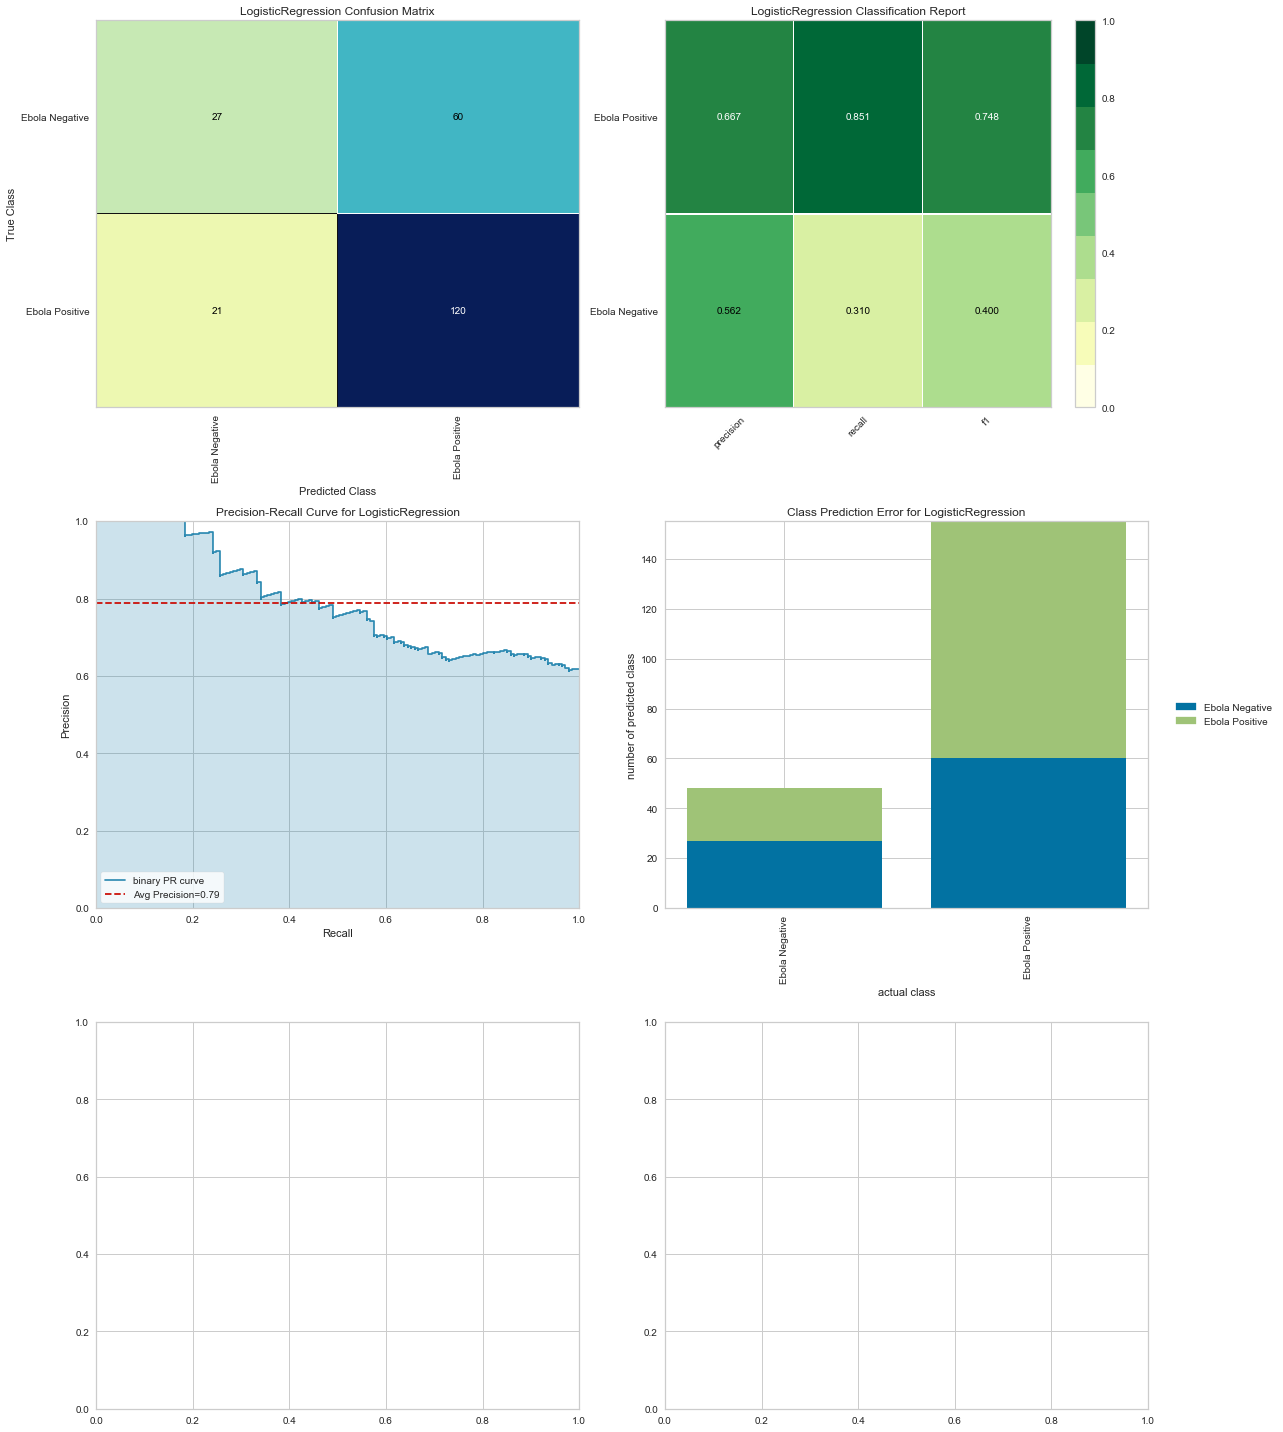

In [667]:
logit = LogisticRegression(penalty = clf.best_params_['penalty'], C = clf.best_params_['C'])
score_model(X_out_train, y_out_train, X_out_test, y_out_test, logit)

## ML models to predict outcome

# REMEMBER TO USE VALIDATION CURVE TO GET AN IDEA ON THE HYPERPARAMETERS !
# REMEMBER TO DO CROSS VALIDATION FOR HYPERPARAMETERS; AND THEN UPDATING AND THEN CHECKING THE SCORES WITH FUNCTION IN HELPERS